In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexEntropy"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_entropy-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 251s 28ms/step - loss: 0.7616 - acc: 0.7786 - val_loss: 13.8497 - val_acc: 0.0596
Epoch 2/100
9112/9112 [==============================] - 252s 28ms/step - loss: 0.4012 - acc: 0.8815 - val_loss: 1.1040 - val_acc: 0.7363
Epoch 3/100
9116/9116 [==============================] - 251s 28ms/step - loss: 0.0115 - acc: 0.9957 - val_loss: 0.5222 - val_acc: 0.9176
Epoch 66/100
9120/9120 [==============================] - 253s 28ms/step - loss: 0.3191 - acc: 0.9024 - val_loss: 0.3975 - val_acc: 0.8907
Epoch 7/100
9120/9120 [==============================] - 247s 27ms/step - loss: 0.2786 - acc: 0.9152 - val_loss: 1.0802 - val_acc: 0.7096
Epoch 8/100
9120/9120 [==============================] - 253s 28ms/step - loss: 0.2396 - acc: 0.9262 - val_loss: 0.4900 - val_acc: 0.8809
Epoch 9/100
9120/9120 [==============================] - 249s 27ms/step - loss: 0.2010 - acc: 0.9341 - val_loss: 0.9529 - 

9120/9120 [==============================] - 259s 28ms/step - loss: 0.0226 - acc: 0.9953 - val_loss: 1.6063 - val_acc: 0.7864
Epoch 62/100
9120/9120 [==============================] - 249s 27ms/step - loss: 0.0251 - acc: 0.9921 - val_loss: 2.2477 - val_acc: 0.5955
Epoch 63/100
9120/9120 [==============================] - 251s 27ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.3408 - val_acc: 0.9301
Epoch 64/100
9120/9120 [==============================] - 252s 28ms/step - loss: 0.0180 - acc: 0.9939 - val_loss: 2.2666 - val_acc: 0.7195
Epoch 65/100
9120/9120 [==============================] - 258s 28ms/step - loss: 0.0185 - acc: 0.9937 - val_loss: 3.1595 - val_acc: 0.6388
Epoch 66/100
9120/9120 [==============================] - 253s 28ms/step - loss: 0.0126 - acc: 0.9950 - val_loss: 2.1176 - val_acc: 0.6516
Epoch 67/100
9120/9120 [==============================] - 254s 28ms/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.3515 - val_acc: 0.9370
Epoch 68/100
9120/9120 [================

9120/9120 [==============================] - 250s 27ms/step - loss: 0.0505 - acc: 0.9839 - val_loss: 0.3198 - val_acc: 0.9262
Epoch 20/100
9120/9120 [==============================] - 251s 27ms/step - loss: 0.0498 - acc: 0.9841 - val_loss: 0.4230 - val_acc: 0.8947
Epoch 21/100
9120/9120 [==============================] - 246s 27ms/step - loss: 0.0553 - acc: 0.9821 - val_loss: 6.7884 - val_acc: 0.4449
Epoch 22/100
9120/9120 [==============================] - 248s 27ms/step - loss: 0.0493 - acc: 0.9838 - val_loss: 0.9329 - val_acc: 0.7854
Epoch 23/100
9120/9120 [==============================] - 247s 27ms/step - loss: 0.0327 - acc: 0.9893 - val_loss: 0.3131 - val_acc: 0.9409
Epoch 24/100
9120/9120 [==============================] - 250s 27ms/step - loss: 0.0326 - acc: 0.9900 - val_loss: 2.9336 - val_acc: 0.5551
Epoch 25/100
9120/9120 [==============================] - 248s 27ms/step - loss: 0.0259 - acc: 0.9924 - val_loss: 1.3154 - val_acc: 0.7854
Epoch 26/100
9120/9120 [================

9127/9127 [==============================] - 263s 29ms/step - loss: 0.0044 - acc: 0.9990 - val_loss: 0.4647 - val_acc: 0.8622
Epoch 62/100
9127/9127 [==============================] - 258s 28ms/step - loss: 0.0181 - acc: 0.9941 - val_loss: 1.5634 - val_acc: 0.7948
Epoch 63/100
9127/9127 [==============================] - 266s 29ms/step - loss: 0.0346 - acc: 0.9897 - val_loss: 0.3262 - val_acc: 0.9425
Epoch 64/100
9132/9132 [==============================] - 168s 18ms/step - loss: 0.0016 - acc: 0.9997 - val_loss: 0.2559 - val_acc: 0.9622
Epoch 82/100
9132/9132 [==============================] - 181s 20ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.2568 - val_acc: 0.9641
Epoch 83/100
9132/9132 [==============================] - 194s 21ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.2589 - val_acc: 0.9651
Epoch 84/100
9132/9132 [==============================] - 210s 23ms/step - loss: 9.8087e-04 - acc: 0.9998 - val_loss: 0.2627 - val_acc: 0.9641
Epoch 85/100
9132/9132 [============

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9314


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

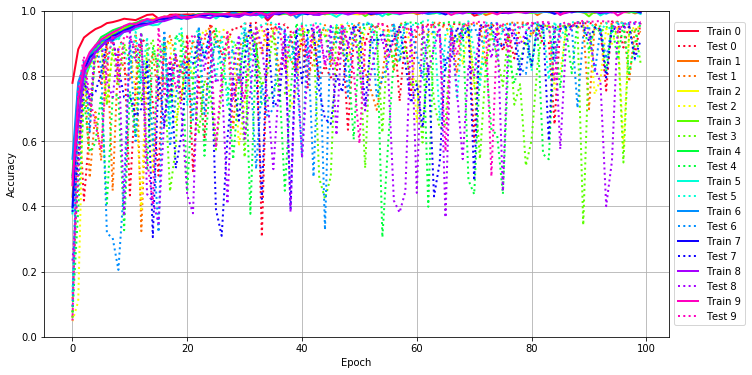

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

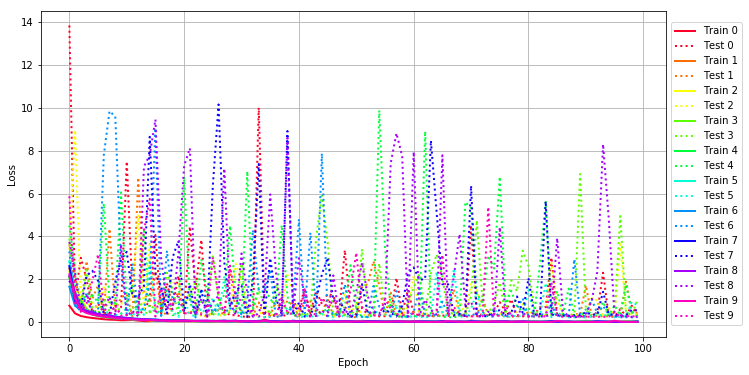

In [ ]:
plot_loss(history)

Plotting the confusion matrix


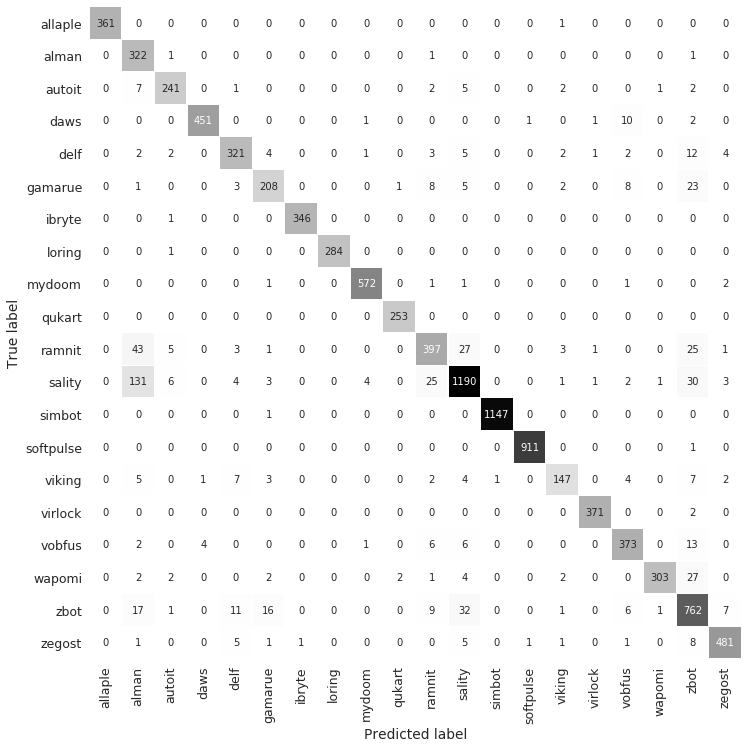

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


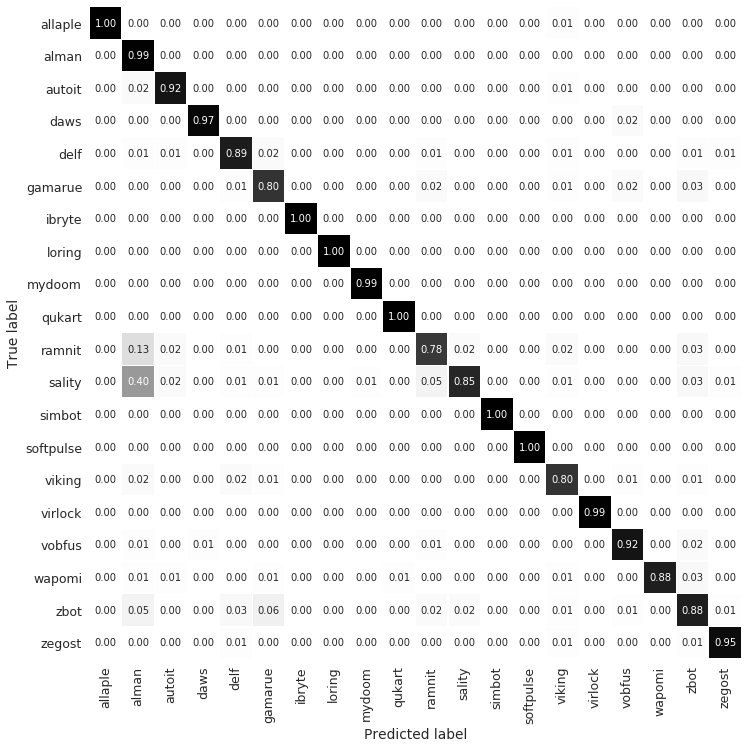

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'val_loss': [13.849680438637733, 1.1040133582504739, 3.000642939951149, 2.0059170259628445, 0.43593237978747545, 0.8695494371470431, 0.4278155082912045, 0.3979606838860015, 0.319107641826637, 0.6124974761791591, 7.497155969265975, 1.3068277067906706, 0.38426016999004275, 0.5101816811651632, 1.0821936168915731, 4.059353048507035, 0.4054641291503982, 1.8133514570299667, 0.706886058355011, 2.1639399567509088, 0.3525849480433636, 4.456276407861878, 1.5564123494737032, 3.8390893395477477, 0.24307021337246804, 0.42227188865047083, 0.650778576602193, 0.5668374071122315, 0.30619553150863243, 0.3294417159841174, 0.25326965282502556, 0.24729981044102534, 0.23862949437109338, 10.014786455780268, 0.48249757260409254, 0.26657421503525347, 0.3644733157954474, 0.25942632231490403, 0.35485274297673675, 0.9715288214706281, 0.5749430080393836, 1.5637725076628115, 0.41360800496852335, 1.4535469864250739, 0.8418079436875132, 1.311013045459731, 1.2246723721496093, 0.3648884646875037, 3.353346721467915, 0.

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

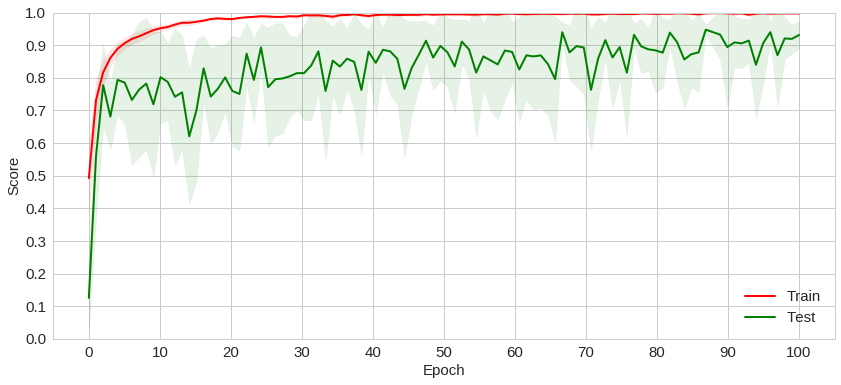

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

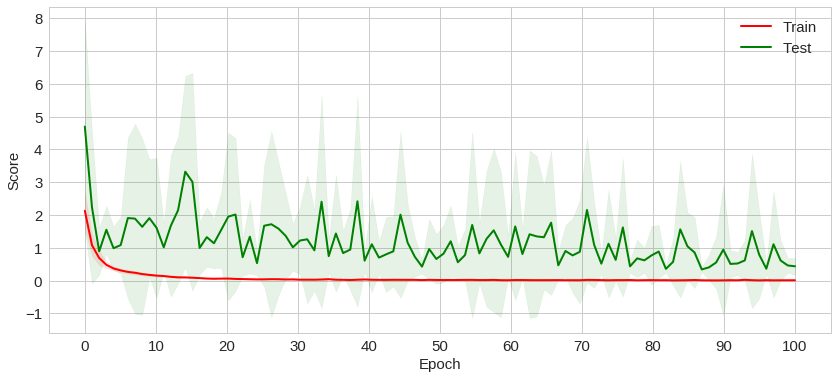

In [ ]:
plot_mean_loss(history)

In [2]:
hist = [{'val_loss': [13.849680438637733, 1.1040133582504739, 3.000642939951149, 2.0059170259628445, 0.43593237978747545, 0.8695494371470431, 0.4278155082912045, 0.3979606838860015, 0.319107641826637, 0.6124974761791591, 7.497155969265975, 1.3068277067906706, 0.38426016999004275, 0.5101816811651632, 1.0821936168915731, 4.059353048507035, 0.4054641291503982, 1.8133514570299667, 0.706886058355011, 2.1639399567509088, 0.3525849480433636, 4.456276407861878, 1.5564123494737032, 3.8390893395477477, 0.24307021337246804, 0.42227188865047083, 0.650778576602193, 0.5668374071122315, 0.30619553150863243, 0.3294417159841174, 0.25326965282502556, 0.24729981044102534, 0.23862949437109338, 10.014786455780268, 0.48249757260409254, 0.26657421503525347, 0.3644733157954474, 0.25942632231490403, 0.35485274297673675, 0.9715288214706281, 0.5749430080393836, 1.5637725076628115, 0.41360800496852335, 1.4535469864250739, 0.8418079436875132, 1.311013045459731, 1.2246723721496093, 0.3648884646875037, 3.353346721467915, 0.49478040284862423, 0.34022291827186635, 0.6900725541725663, 0.3071206105496387, 0.3340475426661098, 0.2615455234797093, 0.2718199629046758, 0.29869930631724273, 2.0544240574537302, 0.3997322902341991, 1.5040994663202158, 0.4073597489016616, 0.2889080306978591, 0.28298815518653964, 0.2819513224296841, 0.29468052230778286, 0.2978292094556423, 0.28828066829016397, 0.28136016787076734, 0.34678918640051615, 0.2730941175387023, 4.5075778174508905, 0.34785384234874117, 0.33936144768095966, 0.2974270482037915, 0.4209663072217471, 0.9270007307171815, 0.48788258226073866, 1.0580873273756368, 0.27470789606643553, 0.2755404610743848, 0.2953061800866452, 0.3358915037620873, 0.6931720546449336, 0.6918093826242275, 3.0115816878156636, 0.2869290053711664, 0.34469844377373215, 0.2476081418928584, 0.25698137959543654, 0.263921554341354, 0.2561407853884665, 0.2595641043018029, 0.45791035844202455, 2.300817848152187, 0.24291818134541998, 0.2549780425644217, 0.5979804944881737, 0.28797658540969007, 0.7596186858618181, 0.2633065946867177], 'val_acc': [0.0595703125, 0.736328125, 0.41796875, 0.640625, 0.8974609375, 0.76953125, 0.9013671875, 0.8994140625, 0.921875, 0.880859375, 0.43359375, 0.7724609375, 0.912109375, 0.9013671875, 0.712890625, 0.494140625, 0.9169921875, 0.732421875, 0.859375, 0.72265625, 0.9267578125, 0.5078125, 0.796875, 0.607421875, 0.9599609375, 0.9248046875, 0.86328125, 0.90625, 0.947265625, 0.9453125, 0.9599609375, 0.9609375, 0.962890625, 0.306640625, 0.9296875, 0.9521484375, 0.943359375, 0.9580078125, 0.9384765625, 0.8203125, 0.912109375, 0.76171875, 0.931640625, 0.7880859375, 0.8310546875, 0.794921875, 0.806640625, 0.9375, 0.634765625, 0.9052734375, 0.951171875, 0.8994140625, 0.9541015625, 0.9501953125, 0.958984375, 0.951171875, 0.95703125, 0.72265625, 0.919921875, 0.7412109375, 0.94921875, 0.955078125, 0.95703125, 0.95703125, 0.9580078125, 0.955078125, 0.958984375, 0.958984375, 0.95703125, 0.958984375, 0.5986328125, 0.9462890625, 0.9521484375, 0.95703125, 0.9482421875, 0.876953125, 0.92578125, 0.853515625, 0.9560546875, 0.9609375, 0.9619140625, 0.9560546875, 0.89453125, 0.9013671875, 0.6513671875, 0.9560546875, 0.953125, 0.9599609375, 0.9619140625, 0.9609375, 0.9619140625, 0.9599609375, 0.9404296875, 0.7548828125, 0.966796875, 0.9658203125, 0.88671875, 0.9560546875, 0.8662109375, 0.9619140625], 'loss': [0.7616120053028411, 0.4011609958152796, 0.2789461993668768, 0.22525537573945847, 0.187025413360517, 0.15787331204243246, 0.128003103869515, 0.10902107521708436, 0.10076748414817115, 0.07875198442726032, 0.08243363283581122, 0.09151380179577472, 0.06509422290828193, 0.04302647503538922, 0.039095146670451844, 0.0793129968842454, 0.07639705202308393, 0.0400934552840422, 0.03645853187722874, 0.03613299159572277, 0.03560276705917536, 0.036096836994132284, 0.03988118470537896, 0.033123542335235186, 0.029440267482090537, 0.025303346678455733, 0.0500375770801626, 0.02815716740529828, 0.011968147207786752, 0.007676890191015319, 0.0038782537322804176, 0.0028851179920166494, 0.0035357559060439224, 0.03266382592848356, 0.1088479600214711, 0.04053931408093141, 0.019314831359866624, 0.004435378132557266, 0.018769058082605074, 0.01480229466474528, 0.03064630629479813, 0.03023488261500943, 0.020437129778833794, 0.01239399215215396, 0.007415504075235461, 0.031150725606316966, 0.011974958655577038, 0.018780208049297115, 0.01814000179114025, 0.017840070061261346, 0.008467098655481741, 0.003865183168916372, 0.014230206137366561, 0.021819975205905312, 0.02029144174097617, 0.00623707929344603, 0.0028233464201518144, 0.01214073246202777, 0.02035605516687026, 0.01975026406799292, 0.01524011526099913, 0.005239636517131311, 0.0022940256484101007, 0.0008049931430012994, 0.0005777929136072526, 0.0020269919311319104, 0.0006499670083951325, 0.000594315854584543, 0.0006111728708581466, 0.0007346202361452899, 0.06446832680514607, 0.03509159681728596, 0.006956770654769642, 0.004658452761944943, 0.0069664072529643985, 0.024970872877426595, 0.03079919165036578, 0.006062088480023203, 0.005682704790301578, 0.002771211827398518, 0.0016584812182901052, 0.006603886899558229, 0.005665730778382152, 0.01198843683971857, 0.023518769531147996, 0.019020366631381385, 0.004498829895197412, 0.002692568129719895, 0.0007145423868076664, 0.0006393373227422226, 0.000530207153039409, 0.0006158134433940796, 0.031234503651013722, 0.019664796725509557, 0.0033875315620494066, 0.0023307663308072776, 0.009152431500385133, 0.016372080889903388, 0.003916951408779589, 0.0015221986787222579], 'acc': [0.7786435470756886, 0.8814749781555832, 0.9174714662507504, 0.9312993855304734, 0.9434811237928007, 0.9508340650739326, 0.9616988587525982, 0.964771729639688, 0.9694907814918431, 0.9751975417555792, 0.9731123792800702, 0.9709174715185291, 0.9787093942054433, 0.9868305531167691, 0.9885864793678666, 0.9756365233183535, 0.974539069359087, 0.9874890254609306, 0.9880377524143986, 0.987379280070237, 0.9883669886911407, 0.9878182616330115, 0.986501316997019, 0.9883669885864794, 0.9911106233538192, 0.9917690956979807, 0.9861720807726075, 0.9913301141352063, 0.9961589113257243, 0.9972563652326603, 0.9992317822651449, 0.9992317822651449, 0.9990122914837577, 0.9907813871817384, 0.9696005267778753, 0.9882572431957858, 0.9948419666374012, 0.9985733099209834, 0.9947322212467077, 0.99571992976295, 0.9901229148375769, 0.9904521510096576, 0.9927568043188844, 0.9967076383838537, 0.9976953467954346, 0.9905618964003512, 0.9955004389815628, 0.9950614574187884, 0.9933055312723523, 0.9941834942932397, 0.997585601404741, 0.9987928007023705, 0.9958296751536435, 0.9939640035118525, 0.9944029850746269, 0.9982440737489026, 0.9989025460930641, 0.9970368744512731, 0.9935250219490781, 0.9942932396839332, 0.9953906935908692, 0.9987928007023705, 0.9995610184372257, 0.9997805092186128, 0.9998902546093064, 0.999451273046532, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9845258999122037, 0.9893546971027217, 0.9979148375768218, 0.9987928007023705, 0.9979148375768218, 0.9933055311676909, 0.9923178226514486, 0.9983538191395961, 0.9981343283582089, 0.999451273046532, 0.9995610184372257, 0.9983538191395961, 0.9984635645302897, 0.9963784021071115, 0.9926470588235294, 0.9941834942932397, 0.9985733099209834, 0.9992317822651449, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9907813871817384, 0.9942932396839332, 0.9993415276558385, 0.999451273046532, 0.9975856014570716, 0.9949517120280948, 0.9991220368744512, 0.9997805092186128]},
{'val_loss': [3.6222026035510395, 2.1578914303835592, 0.5772693628891393, 2.845266553024723, 1.0865085144798816, 1.7084322208411074, 0.31988385941591907, 4.349108604506504, 0.541632629449934, 1.1411195204752087, 1.2915930504784892, 0.23576387778950747, 6.743606668162486, 1.4331419842591995, 0.7432473279800353, 2.375224114118341, 0.607390599688613, 0.29110901902485203, 0.837878047551166, 1.4112979978781013, 0.6454394649971211, 0.3516789973852482, 0.8803174889966605, 0.39677645475129625, 0.22188912107280165, 0.5266322066214025, 0.5510583082984901, 0.3323011726986009, 2.4405344196844942, 0.4861990659448455, 0.5842257635510753, 0.2320214208773695, 0.2762553497053252, 0.9146551372875334, 0.22277506578890577, 0.29787020036280487, 0.984689394451464, 0.5374620274616133, 0.9870320245725945, 0.7669442965732906, 0.2670733810966719, 0.9482025836964381, 0.9731052025817516, 0.4585204740825691, 0.3768862687305641, 1.1129177728908113, 0.26352480561534897, 0.5298635736312934, 0.34520426926596864, 0.23167782968526415, 0.22587809532854375, 1.6222876111471956, 1.7758072217493641, 2.8447100175672215, 1.6880594439135068, 0.2811426923706502, 1.3720249090846164, 0.2683092102912294, 0.2410181616750447, 0.46180199652661835, 0.4496790048034082, 0.5079297353133451, 0.35047219312190314, 0.2674976897649658, 0.24887027771205616, 0.45990528605638376, 0.3963512293580233, 1.5205957414971942, 0.31891827701284897, 0.31219719878971053, 0.269503183039156, 0.2833752158945561, 1.1320402882665412, 0.2778669809693142, 0.25134038084166255, 0.35243346692732613, 0.258493966304674, 0.242831169696893, 0.27006764730869187, 0.23882354015251372, 0.4871229438015657, 0.39783306602492086, 0.29479530225408695, 0.2985659807578024, 0.4253356567611221, 0.32109085888589806, 0.3836838854046446, 0.27688908354351177, 0.3862978510578912, 0.32880903384980426, 1.711538940128637, 0.3040491051944971, 0.28222864526345703, 0.2586928978781693, 0.2676811117306824, 0.2762171662815236, 0.27616775249376896, 1.8848275211137553, 0.42693434353759807, 0.4341324590289456], 'val_acc': [0.11643835616438356, 0.5254403145112637, 0.843444227939016, 0.48727984414408587, 0.6888454030404585, 0.5401174182294632, 0.9129158522051608, 0.4481409018286987, 0.8767123297002685, 0.8199608622231829, 0.7827788659037909, 0.9305283757338552, 0.32387475701460866, 0.8013698648799888, 0.8708414872798435, 0.7250489253120647, 0.8776908032814817, 0.9227005880172938, 0.8600782797527873, 0.805283758271697, 0.8317025440313112, 0.9099804305283757, 0.8463796486826559, 0.910958904109589, 0.9540117416829745, 0.901174168297456, 0.9099804305283757, 0.9334637974106402, 0.634050882259227, 0.8943248532289628, 0.9011741705136757, 0.9500978473581213, 0.9481409011288399, 0.8659491193737769, 0.9628180039138943, 0.952054794520548, 0.8101761274608381, 0.8933463796477495, 0.8522504901699357, 0.812133072407045, 0.958904109589041, 0.8013698630136986, 0.8385518590998043, 0.9129158532549491, 0.9559686888454012, 0.8297455978020296, 0.9530332681017613, 0.9324853228962818, 0.9530332681017613, 0.9530332681017613, 0.961839530332681, 0.814090020735903, 0.7563600782778865, 0.6956947178756654, 0.7994129167844172, 0.9471624266144814, 0.815068493150685, 0.9598825831702544, 0.9608610567514677, 0.9295499021526419, 0.9178082191780822, 0.9354207436399217, 0.9344422700587084, 0.9628180039138943, 0.9628180039138943, 0.9422700587084148, 0.9452054794520548, 0.8082191780821918, 0.9530332681017613, 0.9559686888454012, 0.9608610567514677, 0.9598825831702544, 0.8356164402224546, 0.9579256360078278, 0.9569471624266145, 0.9530332681017613, 0.961839530332681, 0.9637964774951077, 0.961839530332681, 0.9657534246575342, 0.923679060665362, 0.9530332681017613, 0.9549902152641878, 0.952054794520548, 0.9422700587084148, 0.9530332681017613, 0.949119373776908, 0.958904109589041, 0.9481409001956947, 0.9549902152641878, 0.697651664104947, 0.9549902152641878, 0.9608610567514677, 0.9628180039138943, 0.958904109589041, 0.9657534246575342, 0.9628180039138943, 0.7818003913894325, 0.9461839539664132, 0.9334637964774951], 'loss': [2.5008891442639802, 1.3767618435319118, 0.8115247859880541, 0.46916044877696145, 0.3633768186970502, 0.31461601684248863, 0.2644672602568772, 0.21510071148991664, 0.1867553607456669, 0.1613541841768554, 0.1438531061572701, 0.11410066485241471, 0.10922712305082886, 0.106832182393114, 0.08781239155018594, 0.07128282892461543, 0.05693707994819145, 0.06494643429851346, 0.05076963778823084, 0.05603883926553739, 0.058726824254340344, 0.035529841963608054, 0.05138642002918547, 0.04044521508050892, 0.03080300531237263, 0.031104297709426687, 0.03923287962596853, 0.032096297331281054, 0.03852599831979574, 0.026959957314084168, 0.03228167301161995, 0.037599585165995396, 0.0193769745272339, 0.01875307117377804, 0.015804782166816696, 0.019910159665525708, 0.038360721692214765, 0.02732929266324103, 0.019606183227850585, 0.032904413105115854, 0.01982505118098269, 0.011396777426162524, 0.013748623726991472, 0.023217997147157745, 0.021971763702496382, 0.024959413451366142, 0.03161567274385974, 0.011741671647337037, 0.01121544875847632, 0.007753741407651449, 0.004421716990952946, 0.010821006992063986, 0.04443698906785133, 0.03180975983383668, 0.017968764436272048, 0.010043891681803838, 0.007351159105103163, 0.006913442334829411, 0.0063336851442999725, 0.008194578438031133, 0.03809047041920504, 0.023034263452039228, 0.0065375510957231785, 0.005601372491290292, 0.009083761365849258, 0.015913128704433545, 0.020486093358276097, 0.01532465245940845, 0.008634006527963914, 0.004465374346085619, 0.002224976433880428, 0.0020792465041008204, 0.04645570409695413, 0.02126537380131887, 0.005651693936477004, 0.010720502483167943, 0.006341947529625954, 0.0028312477406910955, 0.0025409241262534534, 0.002182487847118353, 0.0021996698056137103, 0.04630262696043795, 0.01074752428764062, 0.008120529729859237, 0.0074717197935125785, 0.007233922308758785, 0.00248648678876556, 0.0015187681290306115, 0.0065664751138646915, 0.01864414741822324, 0.020771845142027765, 0.022645926080111813, 0.007118599663156699, 0.0015371294632189128, 0.0017064346000700667, 0.003211129565346618, 0.0020863619828410044, 0.0016782971642334062, 0.028690703773870757, 0.014719600082471968], 'acc': [0.4294491990344525, 0.7021066491635766, 0.8010752690395608, 0.8567039719113452, 0.893021725002077, 0.9056396753295671, 0.9175992977836296, 0.9318630679908855, 0.9395435593592275, 0.9497476410834392, 0.9575378539427765, 0.962585034105164, 0.9643405749396533, 0.9685099846390169, 0.9721307878905492, 0.9764099188062322, 0.9825543120473996, 0.9798112794420084, 0.9849681808207154, 0.9825543121389582, 0.9813473777523003, 0.989137590520079, 0.9835418040014187, 0.9868334432377583, 0.9915514592933948, 0.9902348036904175, 0.9877112135176651, 0.9911125740618828, 0.9878209349171018, 0.9912222953697608, 0.9902348035988588, 0.9883695414564917, 0.9934167215273206, 0.9938556067588326, 0.9951722624533684, 0.9940750493745886, 0.9878209348255431, 0.9904542462146149, 0.9937458854509545, 0.9911125740618828, 0.9931972789115646, 0.9959403116085144, 0.9952819837612464, 0.9931972789115646, 0.9933070002194426, 0.9924292297564187, 0.9906736888303709, 0.9971472459951722, 0.9960500329163924, 0.9973666887024868, 0.9982444590739522, 0.9965986394557823, 0.9871626069782752, 0.9906736888303709, 0.9948430985297345, 0.9963791968400263, 0.9973666887024868, 0.9970375246872942, 0.9976958525345622, 0.9974764099188063, 0.989027869212201, 0.9931972789115646, 0.9979152951503182, 0.9980250164581962, 0.9973666886109283, 0.9950625411454904, 0.9936361641430765, 0.9958305903006364, 0.9969278033794163, 0.9985736229975861, 0.9993416721527321, 0.999231950844854, 0.9863945578231292, 0.9925389510642967, 0.9983541803818301, 0.9971472460867309, 0.9979152951503182, 0.999122229536976, 0.999231950844854, 0.999231950844854, 0.9993416721527321, 0.9862848366983684, 0.9967083607636603, 0.9979152951503182, 0.9976958525345622, 0.9982444591655107, 0.9993416721527321, 0.9994513934606101, 0.9982444591655107, 0.9939653280667106, 0.9946236559139785, 0.9929778362958086, 0.9980250164581962, 0.999780557384244, 0.9995611147684881, 0.999122229536976, 0.9993416721527321, 0.9994513934606101, 0.9914417379855168, 0.9957208689927584]},
{'val_loss': [3.3843952197654574, 8.962968539724162, 0.8088547743966474, 0.7329715369855466, 0.933821744822404, 0.5657345683452327, 1.6262293944034871, 0.7795481673131387, 0.7924122444087498, 0.8702946513959272, 0.8373879589315039, 1.2381783991125321, 5.016603086508956, 0.5103824795171842, 3.6532435613812186, 0.5696740446686425, 1.015078456995566, 0.7605130801594396, 1.846045401864046, 1.7649607948088042, 0.7852843403519478, 1.4561561561007568, 0.774816641461232, 0.26422204504599317, 0.3023867937051417, 0.4001626955930658, 0.3127678323061918, 0.30680855817238933, 0.5513987728800309, 2.7176679357776745, 1.8587664642494501, 0.6337868617109124, 0.33471217571885276, 0.3012213427542796, 0.6311044762297374, 0.3514984889282183, 0.304762730042915, 0.5938477935733424, 2.2030550784084446, 1.3716313876540345, 0.3366831006509653, 0.35489772790213053, 0.5705478013402671, 0.5080274671206718, 0.36953766741504546, 0.284661219757674, 0.2695170555492661, 0.26615202948520816, 1.2807488346195897, 0.3693681174847566, 0.8570527940504048, 0.3459040190214307, 0.3057556021444355, 0.3030248147807318, 0.32225794478710723, 0.3511022719526128, 0.4851348272026371, 0.42207719468596244, 0.31800100602125825, 0.7228395711781108, 2.164727811896432, 0.39813619014908935, 0.35808502604119946, 0.45212995585673604, 0.5221603285742994, 0.47164979605876417, 0.3244282561916786, 0.3859942340606294, 1.0308553231681905, 0.3336974583588431, 1.8073351439991399, 1.5493299871392292, 0.37933490901240047, 0.4371452167257289, 0.3745452695150227, 0.3635102831490343, 0.4116628015284255, 0.4441161900609243, 0.4814615958731012, 0.8280475526426097, 0.48703882179076446, 0.31493916338483813, 0.27067833322331647, 0.31820358974315577, 2.7695514294925254, 0.9530376465787702, 0.31690434738751383, 0.3043108778424896, 0.2925273348358248, 0.3265194657609906, 0.33373473007650767, 1.121377715374932, 1.009864105011502, 0.3306345884281485, 0.6601109109958182, 0.34387850911821977, 3.6304767808499436, 0.3927195601099704, 0.3504416987355122, 0.3401856934598879], 'val_acc': [0.04803921568627451, 0.10882352964550841, 0.8284313739514818, 0.8284313734839944, 0.8539215700299132, 0.8990196083106247, 0.7147058837554034, 0.878431373016507, 0.8892156872094846, 0.885294119049521, 0.8931372558369356, 0.7480392170887368, 0.3843137268926583, 0.8960784323075238, 0.5000000014024623, 0.8892156872094846, 0.8696078445397172, 0.9078431381898768, 0.6578431381898768, 0.7441176484612858, 0.8470588253993614, 0.8029411778730504, 0.910784314660465, 0.9411764715232102, 0.9284313734839944, 0.9245098053240308, 0.9421568636800729, 0.9382352955201093, 0.8931372558369356, 0.5852941185820336, 0.7166666680691289, 0.8745098053240309, 0.9313725504220701, 0.9441176479937984, 0.8833333342683082, 0.943137256304423, 0.9382352950526219, 0.8852941195170084, 0.7029411774055631, 0.7539215704974006, 0.9490196087781121, 0.9323529421114454, 0.8990196083106247, 0.9088235303467396, 0.9284313734839944, 0.9509803930918376, 0.9529411774055631, 0.956862746033014, 0.8401960793663473, 0.9421568636800729, 0.8450980406181485, 0.9450980401506611, 0.9480392166212493, 0.9500000009349748, 0.9392156872094847, 0.9392156872094847, 0.9176470602259916, 0.9343137268926583, 0.9460784323075239, 0.8941176484612857, 0.6568627465005015, 0.9421568641475603, 0.9245098043890561, 0.9323529421114454, 0.9176470592910169, 0.9137254911310533, 0.9529411774055631, 0.9450980401506611, 0.8343137264251709, 0.9490196087781121, 0.7676470597585042, 0.7960784327750112, 0.9470588244643866, 0.9343137264251709, 0.9352941185820336, 0.9382352950526219, 0.9431372558369356, 0.9401960793663474, 0.9196078445397171, 0.8941176479937983, 0.9274509813271317, 0.9460784323075239, 0.9558823538761513, 0.9539215695624258, 0.7607843141929777, 0.8098039229710897, 0.9500000009349748, 0.9509803930918376, 0.9529411774055631, 0.9500000009349748, 0.9539215695624258, 0.7441176475263109, 0.7882352945851344, 0.9450980401506611, 0.8980392166212493, 0.9470588244643866, 0.5784313739514818, 0.9392156872094847, 0.9490196087781121, 0.9490196087781121], 'loss': [2.3536305276381966, 1.4667162417110093, 1.1124980414368804, 0.6103181625573768, 0.40125938417645807, 0.33446321862996176, 0.2742872719651725, 0.23536763760984963, 0.19567065084775637, 0.16801101513314842, 0.14581707203307137, 0.14488798451739454, 0.11109569415486058, 0.1012424304018867, 0.07629953163274257, 0.0847924786254914, 0.07764129218297629, 0.0535917646830273, 0.04773519324308761, 0.06193284473916048, 0.06106611171074476, 0.046957746017135815, 0.0412811121479177, 0.04250326951329824, 0.032875896015495856, 0.03160872849389157, 0.03670310041230309, 0.055508847704431846, 0.028341770869385108, 0.027866839426092537, 0.026277488907130466, 0.01836220726460511, 0.03556912104429995, 0.033767890972440824, 0.02940472466078609, 0.03345027747674354, 0.01662254098015584, 0.010176650068637792, 0.023531858259793096, 0.03524760723037085, 0.03322663831267303, 0.021236080752678056, 0.013088259284631452, 0.013808048991551814, 0.036329035807967744, 0.014026179058470157, 0.006514024224071883, 0.0039877748088222725, 0.009494660861205729, 0.03491556423060306, 0.03724249670200888, 0.014496944988390187, 0.01392643964595434, 0.02067164817730254, 0.00902291579201796, 0.008696783383198953, 0.015667733276169424, 0.03019726377628975, 0.006173369318408438, 0.007798925672989743, 0.01915436752507276, 0.01844390664784574, 0.022801695456859748, 0.014851456039971914, 0.011489211696030621, 0.0063266940555109005, 0.00566492625743168, 0.0062652840361755256, 0.01702882641674613, 0.020345625948584252, 0.00909105515017583, 0.019556180405479573, 0.012651458216174962, 0.005214016323167278, 0.008691489604206333, 0.010170238799272155, 0.005121473971461557, 0.007968357146718586, 0.009809538632391783, 0.022691707539832948, 0.02751574618026087, 0.006258459888911597, 0.0038618970033625208, 0.0034256541201756353, 0.007231738304801104, 0.025935311190811345, 0.005641228132909894, 0.002693020745366967, 0.0024126898651895307, 0.004100928158562204, 0.0036631743701645205, 0.0062092703513361045, 0.04290930650416506, 0.009027637651504583, 0.013054299949054191, 0.007026660568597183, 0.007685669992342782, 0.012962902466515061, 0.004456909883695769, 0.003305217202290775], 'acc': [0.4636902150588896, 0.6816586222550282, 0.7686485301355042, 0.8457656867570028, 0.8814172883366429, 0.8966652041414737, 0.9148749453083054, 0.9260640632379155, 0.9356077227900038, 0.9454804739966733, 0.9549144362085166, 0.954146555559109, 0.9637999122422115, 0.9684071961386573, 0.9758666081614743, 0.9719175077311142, 0.9749890303810524, 0.9826678368228211, 0.9851908731899957, 0.9805835892935498, 0.9816805617021541, 0.9848617815354144, 0.9887011847301448, 0.9867266345411186, 0.9885914874945151, 0.9907854322594161, 0.9878236068451075, 0.9821193506446728, 0.9905660377881568, 0.9913339183852566, 0.992211496270294, 0.9944054409828872, 0.9880430013163668, 0.9891399736726635, 0.9906757349714788, 0.9894690653795525, 0.9944054409828872, 0.9973672663448881, 0.9925405879771829, 0.9888108820180822, 0.9893593681439228, 0.9933084686265906, 0.9955024133914916, 0.9950636243966652, 0.9879333040807372, 0.9962702939885915, 0.9973672663448881, 0.998683633172444, 0.9965993857477882, 0.9894690653795525, 0.9887011847301448, 0.9953927161035542, 0.9957218078627509, 0.9936375603334796, 0.9972575691092584, 0.9963799912242212, 0.9958315050983806, 0.9904563405002194, 0.998354541465555, 0.9971478718736287, 0.993418165914528, 0.9936375603857873, 0.9923211935582313, 0.9961605967529619, 0.9957218078104432, 0.998025449758666, 0.9978060552874067, 0.9979157525753442, 0.9946248354541466, 0.9933084686265906, 0.9967090829311102, 0.9939666520403686, 0.9964896884598509, 0.9974769635805177, 0.9970381746379992, 0.9962702939885915, 0.9978060552874067, 0.9972575691092584, 0.9972575691092584, 0.9945151382185169, 0.9924308907415533, 0.9976963580517771, 0.998683633172444, 0.998683633172444, 0.9976963580517771, 0.9917727073277753, 0.998025449758666, 0.9991224221672704, 0.9991224221149627, 0.9985739359368144, 0.9987933304080737, 0.9979157525230364, 0.9881526985519965, 0.9974769635805177, 0.9963799912765289, 0.9978060552874067, 0.9974769635805177, 0.9960508995173322, 0.998025449758666, 0.9989030276437034]},
{'val_loss': [3.894353359703004, 1.0539430456774999, 0.8802136611500498, 2.420299087274099, 0.6236670166609248, 0.3975007168840485, 1.0802226072382621, 0.4900187589395443, 0.9529393487133262, 0.39902322183411165, 0.6350139991031857, 0.5600782315979427, 1.2106152800971453, 0.4558681003071847, 0.39034336788150864, 0.9843027802462888, 0.7680234301371858, 2.3047142858199012, 1.4898553914631127, 0.33070473186208216, 0.7634308125867736, 1.0266107789378964, 1.9557918285864853, 0.878080334676914, 0.9291330671400944, 3.1487698600752148, 1.0734119804174544, 0.3348460520388457, 0.4682868423959466, 0.4566737092892732, 2.728422688853773, 0.3160836997082655, 0.5536379754778646, 1.4707338404007564, 0.8385362761882601, 0.35878684537155725, 1.7360040783354147, 1.1727928086523132, 0.3915780115064088, 0.38109178218590073, 0.3970663542739657, 0.3335036254942814, 0.40945758274971256, 3.906182375773201, 5.91519316054118, 3.7461403492163488, 0.32464102288760815, 0.46548239558409, 0.3055127674828122, 0.2801578082697687, 0.6626807034033086, 3.4012557596672237, 0.35491409038485155, 0.3584907145674916, 2.7409777282847196, 0.4465620333253355, 0.9278491798833084, 0.7349766912167951, 0.5297768997995221, 0.8508456059134919, 1.6062624882141483, 2.247700728992354, 0.3408296675215349, 2.266552515767972, 3.159545981918286, 2.117561072770435, 0.35150813552837823, 0.4576901007976711, 0.3468319165408417, 0.34444370727426643, 1.1738153937913065, 4.741662358791809, 0.9284050929405561, 0.4437798402709193, 0.8164426514692005, 1.8437291902646538, 0.3764927744857924, 1.9435031140486, 1.4282124817661934, 3.3253145426746427, 2.60594857657419, 0.6480667484056548, 0.30862782951853357, 0.3267256202095074, 0.3309390622071897, 0.327668517973924, 0.31512126300311444, 0.3284283916465247, 0.3309488994402951, 6.911813668026699, 0.5956268395428669, 0.2781405227074076, 0.3709307611928771, 0.2902206972404021, 0.3082026090259994, 0.3910014569582309, 4.947737913666748, 0.43765116545258803, 0.3306096845753144, 1.035564539917175], 'val_acc': [0.058070866141732284, 0.6732283464566929, 0.8080708661417323, 0.6732283464566929, 0.8562992130677531, 0.890748031496063, 0.7096456692913385, 0.8809055118110236, 0.7706692918079106, 0.8986220477134224, 0.8454724414142099, 0.8740157480314961, 0.7204724414142099, 0.8690944881889764, 0.9114173228346457, 0.7933070870835012, 0.8031496067685405, 0.44586614220161136, 0.5807086618866507, 0.9311023622047244, 0.8503937007874016, 0.78051181149295, 0.6220472440944882, 0.7854330713354697, 0.7490157480314961, 0.5738188976377953, 0.7529527559055118, 0.9124015748031497, 0.9035433070866141, 0.8799212598425197, 0.5501968503937008, 0.9419291343275956, 0.890748031496063, 0.7696850398394066, 0.8090551181102362, 0.9340551181102362, 0.7401574807842886, 0.7460629921259843, 0.9281496062992126, 0.9242125988945248, 0.9291338582677166, 0.9409448818897638, 0.9271653543307087, 0.4862204724409449, 0.42322834692602085, 0.4911417322834646, 0.9419291338582677, 0.8956692918079106, 0.9438976382646035, 0.9468503937007874, 0.8720472440944882, 0.5177165359023987, 0.9399606299212598, 0.9350393700787402, 0.6259842519685039, 0.9261811023622047, 0.8307086614173228, 0.8523622047244095, 0.889763779527559, 0.7687007874015748, 0.7864173233039736, 0.5954724414142099, 0.9301181107055484, 0.7194881894457059, 0.6387795275590551, 0.6515748036189342, 0.937007874015748, 0.9045275590551181, 0.9419291338582677, 0.9458661422016114, 0.7933070866141733, 0.545275591489837, 0.8248031500756271, 0.9281496062992126, 0.859251968503937, 0.7687007878709027, 0.9429133862960996, 0.7116141736976743, 0.7746062996819263, 0.5246063001512542, 0.6033464566929134, 0.8297244099181468, 0.9527559059811389, 0.951771654012635, 0.951771654012635, 0.9498031500756271, 0.9547244099181468, 0.9547244099181468, 0.9537401579496428, 0.3425196859780259, 0.8789370078740157, 0.9507874015748031, 0.9340551181102362, 0.9498031496062992, 0.9468503937007874, 0.9291338587370445, 0.5344488193669658, 0.9320866141732284, 0.9448818897637795, 0.8385826776346822], 'loss': [2.082807559506935, 1.231666498226032, 0.9619760241947676, 0.6215992296735445, 0.392722403375726, 0.31913962188389217, 0.2785891248860903, 0.239551105252222, 0.20095436178278506, 0.17939764005050324, 0.15061937442800977, 0.14117141082196644, 0.1131129144396829, 0.09157532600179445, 0.09975953267380726, 0.08387385922598473, 0.0718070003702387, 0.060330364531265536, 0.05918826360047157, 0.056180375861616706, 0.07553899670816272, 0.05098733189158354, 0.03524799348797707, 0.031844896459012506, 0.025445860920355477, 0.0336038825752136, 0.05624312705507404, 0.04604987330732688, 0.024618696320797887, 0.021956243143537443, 0.026437770609903197, 0.02636652274170621, 0.04485188521906374, 0.015386730376434442, 0.013922794065065478, 0.024644032467652944, 0.03253711315552018, 0.028875007070695447, 0.023009302208989984, 0.027739777182024115, 0.018563053634508768, 0.012890301786625825, 0.009496934039698477, 0.02987784424623354, 0.030551110157868704, 0.030958817945257146, 0.012839855383731846, 0.012717224386838017, 0.008072236608825877, 0.004840535694366784, 0.01205049316935194, 0.0604662783125828, 0.017662647527833, 0.012830129851183876, 0.013880277615486162, 0.023666104097158, 0.019384008510959366, 0.00984018942654314, 0.008801647153717439, 0.016499637742029002, 0.02255237040251239, 0.025104043714364116, 0.005847688415309548, 0.01795624314597597, 0.018527131451301422, 0.01256616838120368, 0.007343327671658603, 0.005857556662768777, 0.00854134249332977, 0.006685608678074124, 0.01832593640406071, 0.024851528857994198, 0.01664676592784401, 0.009952342612003824, 0.010219285398479291, 0.006671578515264978, 0.004304160731895504, 0.013476784386535942, 0.013272457514509976, 0.015506564618896702, 0.018635209032529593, 0.00863964111902437, 0.0035792965811053457, 0.0027644295716375685, 0.002550923432939375, 0.0030523553313283277, 0.0031263055053701912, 0.002794571287998886, 0.00229144080507519, 0.014217644944972506, 0.059200109062785805, 0.006036321612322226, 0.0070464269241344015, 0.002762819765846695, 0.004423556360277895, 0.009403175942268143, 0.015395398809455958, 0.016729592427180792, 0.004134222091129072, 0.0050050124628308115], 'acc': [0.4837719298245614, 0.7198464912280702, 0.7846491228070176, 0.8323464912280701, 0.8820175438596491, 0.9024122807017544, 0.9152412280701754, 0.9262061403508772, 0.9341008771929824, 0.9435307017543859, 0.9526315789473684, 0.9543859649122807, 0.9632675438596491, 0.9720394736842105, 0.9685307017543859, 0.9717105263157895, 0.9758771929824561, 0.981140350877193, 0.981140350877193, 0.9809210526315789, 0.9740131578947369, 0.9833333333333333, 0.9891447368421052, 0.9903508771929824, 0.9925438596491228, 0.9894736842105263, 0.9827850877192983, 0.9853070175438596, 0.9924342105263158, 0.9915570175438596, 0.9924342105263158, 0.9914473684210526, 0.9856359649122807, 0.9949561403508772, 0.9952850877192982, 0.9928728070175439, 0.9892543859649123, 0.9905701754385965, 0.9927631578947368, 0.9905701754385965, 0.9947368421052631, 0.9966008771929824, 0.9972587719298246, 0.9902412280701754, 0.9904605263157895, 0.9898026315789473, 0.9962719298245614, 0.9955043859649123, 0.9978070175438597, 0.9983552631578947, 0.9966008771929824, 0.9831140350877193, 0.9944078947368421, 0.9962719298245614, 0.9953947368421052, 0.9922149122807018, 0.993530701754386, 0.9971491228070175, 0.9973684210526316, 0.9942982456140351, 0.9952850877192982, 0.9921052631578947, 0.9981359649122807, 0.993859649122807, 0.99375, 0.9949561403508772, 0.9979166666666667, 0.9981359649122807, 0.9968201754385965, 0.9976973684210526, 0.9942982456140351, 0.9919956140350877, 0.9942982456140351, 0.9968201754385965, 0.9968201754385965, 0.9978070175438597, 0.9985745614035088, 0.9955043859649123, 0.9952850877192982, 0.9945175438596491, 0.993421052631579, 0.9973684210526316, 0.9986842105263158, 0.9993421052631579, 0.9990131578947369, 0.9987938596491228, 0.9987938596491228, 0.9989035087719298, 0.9990131578947369, 0.9960526315789474, 0.9824561403508771, 0.9979166666666667, 0.9979166666666667, 0.9992324561403508, 0.9985745614035088, 0.9968201754385965, 0.9956140350877193, 0.9940789473684211, 0.9984649122807018, 0.9986842105263158]},
{'val_loss': [4.511632461247482, 2.362036911286707, 0.8717735160039518, 1.3203891244108283, 1.2526524936355006, 0.9231394802359497, 5.534250998268212, 0.9060272894961041, 0.8936659448677454, 6.054201874383322, 0.9133401545540129, 1.670696783546857, 0.2724324182748126, 4.369591330331164, 0.45940968055102543, 0.558418407338659, 0.3908798729823939, 1.4673933921689828, 0.31984287861397515, 0.4229540692671664, 6.788441239243857, 0.9329067384517793, 0.3131039804042478, 2.933603713995416, 1.3154450681394674, 0.29152344778499023, 0.9448901315624862, 1.2570510237133916, 4.497316178344153, 1.2441031115182184, 0.3534448691715317, 7.036633884229065, 0.6523547921501631, 1.5861994615431911, 1.6347517587160179, 1.0646356068398934, 0.8002058605571928, 4.520575154152611, 1.1988822042898049, 0.2805024503096914, 0.34728597093438535, 0.3112017087863531, 0.3274282816973301, 0.29047613496757463, 0.4349696146715041, 0.6449236612309758, 0.2853897863648346, 0.4646239544224697, 0.7037125802076829, 2.6551638148420786, 0.5246298907069891, 0.2607496035939288, 0.2321304978856924, 0.31274154040767904, 9.882201037625416, 3.4817952485947585, 0.643620760890683, 0.26158013492344734, 0.2701979966844892, 0.2442572840961267, 0.2799963895750479, 0.2741569493953019, 8.901586741063856, 0.32561017403283155, 0.2996336985752959, 0.2482030927498783, 0.2181758367418307, 0.2255198993001753, 0.2441012766117341, 5.605169961779419, 5.305512060213276, 1.3463086638204107, 0.8711894886444521, 3.1008550481301427, 2.4965987253611805, 6.78367059067713, 0.8557173457290824, 1.4501447906476133, 0.715447435512211, 0.5093912052258937, 0.6483694537571096, 0.296838305799689, 2.690671093116903, 5.609367011364287, 0.31725207025448926, 1.4380829212649708, 0.329393712496246, 1.558857564532497, 0.2804761821716039, 0.24320177788881145, 0.591753590858198, 0.35623105486057843, 0.30998918887774257, 0.9467960566452076, 0.30273707347545564, 0.7810940049240956, 0.3025722821465979, 1.7489073677016644, 0.4950999429838694, 0.2294040151701293], 'val_acc': [0.07480314960629922, 0.3897637804662149, 0.7303149610992492, 0.5659448823590917, 0.5944881894457059, 0.7411417327527925, 0.4084645671637978, 0.7362204729102728, 0.7421259847212964, 0.326771653777971, 0.7529527559055118, 0.6151574803149606, 0.9340551185795641, 0.5088582679511994, 0.8858267721228712, 0.8248031500756271, 0.903543307555942, 0.7047244099181468, 0.9261811028315327, 0.8946850398394066, 0.44488188999844347, 0.7854330713354697, 0.9409448823590917, 0.5551181104708844, 0.7854330713354697, 0.9488188981071232, 0.8070866146425563, 0.7687007878709027, 0.5442913388173412, 0.7696850398394066, 0.9251968508630287, 0.3769685041716718, 0.8966535437764145, 0.7135826776346822, 0.7244094492882256, 0.7539370083433437, 0.7972440954268448, 0.4478346459039553, 0.7460629921259843, 0.9616141736976743, 0.9192913390520051, 0.9340551185795641, 0.9242125988945248, 0.9379921264535799, 0.9232283469260208, 0.8562992130677531, 0.9488188985764511, 0.8710629925953122, 0.858267717004761, 0.6053149610992492, 0.9025590555874381, 0.9576771658236586, 0.9576771658236586, 0.950787402044131, 0.3051181102362205, 0.5925196855086979, 0.8562992130677531, 0.9537401579496428, 0.9635826776346822, 0.9635826776346822, 0.9616141736976743, 0.9625984256661783, 0.39862204747875846, 0.951771654012635, 0.9557086618866507, 0.9645669296031861, 0.9645669296031861, 0.9635826776346822, 0.9635826776346822, 0.48031496109924915, 0.437007874250412, 0.8159448823590917, 0.8494094492882256, 0.6358267725921991, 0.6181102364551364, 0.4379921262189159, 0.8622047248787768, 0.7775590555874381, 0.8474409453512177, 0.906496063461454, 0.8316929138551546, 0.9586614177921625, 0.5600393700787402, 0.5442913388173412, 0.9340551185795641, 0.7618110240913751, 0.9498031500756271, 0.8080708666110602, 0.9645669296031861, 0.9645669296031861, 0.8769685044063358, 0.9498031500756271, 0.951771654012635, 0.8129921264535799, 0.9576771658236586, 0.8494094492882256, 0.9606299217291704, 0.8080708666110602, 0.8996063001512542, 0.9625984256661783], 'loss': [2.1228614861505073, 0.7775873828352543, 0.6132813845287289, 0.4658653219802338, 0.34891069808550046, 0.27291964800995694, 0.23399415503076293, 0.19206777041810646, 0.16408039776346925, 0.15343354812806898, 0.13215229903396808, 0.11902436522293117, 0.08995716328030093, 0.0857456545365909, 0.09235885740796987, 0.07305805651234104, 0.06864177330740188, 0.0540972880230759, 0.05050628619909842, 0.049829672469161125, 0.05532914388694049, 0.04932692859964159, 0.03274149310666855, 0.03259851658735179, 0.025943457522825748, 0.022480485398116062, 0.029837556675371607, 0.03980807781397169, 0.032746782825632724, 0.03189449470955878, 0.02371773481537642, 0.028658049374286763, 0.03376412524502436, 0.034055972318026505, 0.013400247447747173, 0.02094488716903837, 0.009541271821833282, 0.020339849335486132, 0.04952699588568322, 0.024078816117540362, 0.009559016581624747, 0.006127511800182299, 0.04031228886468166, 0.01379201199127062, 0.010730614809813632, 0.026143851829266696, 0.012879188171140605, 0.007320171181112401, 0.02881840606486979, 0.020064283243182376, 0.019723856822166822, 0.0077412715413039115, 0.0041192406098720345, 0.0028309757449617614, 0.013927283882036104, 0.03857307197510013, 0.01929106126873162, 0.006718628660113162, 0.0023328672443639923, 0.001105534369699263, 0.0011357720174565225, 0.0025681099199031006, 0.029017086169864214, 0.025394161271718698, 0.011670319246732425, 0.005315844092234057, 0.0014721261625868863, 0.0011595435477717905, 0.0013374441137282127, 0.023233717400731428, 0.01721811032167719, 0.00815029207217122, 0.017267837550315832, 0.010541031617669847, 0.00624770320063474, 0.006477995890877976, 0.01758879354286348, 0.01186442164772304, 0.009316994570113729, 0.007185422251451089, 0.003429137739702351, 0.0017410867210072099, 0.002201845812569764, 0.01871814426384956, 0.012467118498442, 0.0077458033660604995, 0.00635393706078455, 0.010986229480928207, 0.008567576184327264, 0.001633982809812152, 0.004462007742249366, 0.01855756126856768, 0.0205166025669665, 0.018434957778636248, 0.002041443335802565, 0.006063520072607469, 0.003227580223440846, 0.012417236079288255, 0.0210538869486124, 0.002763511842284603], 'acc': [0.49583333333333335, 0.7711622807017544, 0.8158991228070176, 0.8594298245614035, 0.8916666666666667, 0.9190789473684211, 0.9287280701754386, 0.9395833333333333, 0.9461622807017543, 0.9514254385964912, 0.9572368421052632, 0.9614035087719298, 0.9703947368421053, 0.9723684210526315, 0.9699561403508772, 0.9757675438596491, 0.9773026315789474, 0.981469298245614, 0.9838815789473684, 0.9841008771929824, 0.9821271929824561, 0.9837719298245614, 0.9892543859649123, 0.9900219298245614, 0.9924342105263158, 0.9929824561403509, 0.9912280701754386, 0.9862938596491229, 0.9899122807017544, 0.9890350877192983, 0.9928728070175439, 0.9913377192982457, 0.9899122807017544, 0.9893640350877193, 0.9960526315789474, 0.99375, 0.9971491228070175, 0.993859649122807, 0.9853070175438596, 0.9914473684210526, 0.9967105263157895, 0.9981359649122807, 0.987390350877193, 0.9949561403508772, 0.9961622807017544, 0.9921052631578947, 0.9956140350877193, 0.9978070175438597, 0.9922149122807018, 0.9942982456140351, 0.9939692982456141, 0.9976973684210526, 0.9989035087719298, 0.9993421052631579, 0.9961622807017544, 0.987280701754386, 0.99375, 0.9975877192982456, 0.9993421052631579, 0.9997807017543859, 0.9997807017543859, 0.9987938596491228, 0.9907894736842106, 0.9915570175438596, 0.9966008771929824, 0.9983552631578947, 0.999671052631579, 0.999561403508772, 0.999561403508772, 0.9932017543859649, 0.9947368421052631, 0.9972587719298246, 0.9950657894736842, 0.9963815789473685, 0.9979166666666667, 0.9976973684210526, 0.993530701754386, 0.9961622807017544, 0.9973684210526316, 0.9978070175438597, 0.9985745614035088, 0.999561403508772, 0.9993421052631579, 0.9945175438596491, 0.9960526315789474, 0.9974780701754385, 0.9978070175438597, 0.9971491228070175, 0.9967105263157895, 0.9992324561403508, 0.9990131578947369, 0.9950657894736842, 0.993421052631579, 0.9953947368421052, 0.9993421052631579, 0.9986842105263158, 0.9990131578947369, 0.9968201754385965, 0.9942982456140351, 0.9991228070175439]},
{'val_loss': [2.8523519829166157, 1.433701067661791, 0.628094998859864, 0.568746157860534, 0.45677822829950987, 0.35719869359850104, 0.6278518908293264, 0.31429272484024856, 0.30960259558016673, 0.38422836623851, 0.6527673863837151, 0.24107548834450412, 0.7980159473680071, 0.33227100329251147, 2.804710829833156, 0.48536473943484104, 0.2913230540883533, 1.4014974488401426, 0.5093474170500754, 0.2413593534454418, 1.0543770553722875, 0.3504160304952682, 0.2644811985967788, 0.6367701670536302, 0.334796838231019, 1.144381470011011, 0.33621351465280697, 2.0935383143583284, 0.5647442278730417, 0.5547805318820063, 0.23095218448083918, 0.7846569224628303, 0.2714950139858851, 0.23897669570031682, 0.2237848173252341, 0.22976183341176595, 0.3034610815358671, 0.28430558636868725, 0.7029316494900929, 0.37577177919004423, 0.19336259664790967, 0.28701767411366097, 0.25120697230260897, 0.26469433221844796, 0.3724527292930104, 0.2714809851645864, 0.24027843269175117, 0.3532679565603242, 0.23530610343687966, 0.28519924563810944, 0.3782187701265304, 0.232056046923427, 0.22060532256450377, 0.642135017648208, 0.3092612776348081, 0.3431422465530263, 0.25001987291983524, 0.6795772969143031, 0.2039061276011155, 0.2446252837899698, 0.2620100334148698, 0.23667730533792417, 0.2228609911732583, 0.2301456437462008, 2.342543345073682, 0.4124578642129556, 0.26925786163094284, 2.496770191631044, 0.2489625653565597, 0.24280839894490683, 0.6246730355953735, 1.3624988505867233, 0.23571084335265824, 0.26515671088975357, 0.6378146330160425, 0.2739143387969484, 0.25239763604956994, 0.24495583484450822, 0.30480615375883174, 0.24486119773506249, 1.509799802975748, 0.24541490483788472, 0.2609892105674513, 1.820343733535348, 0.2188510406597304, 0.44940845500459825, 0.2810211540725488, 0.22008816029442682, 0.21475304807840034, 0.22885848593789643, 0.21310026495752626, 0.267507273757391, 0.3638115633676412, 0.2607693815632697, 0.40380219248886895, 0.21707672501862127, 0.24470410304949827, 0.2651982363174552, 0.9369735144499217, 0.7757426062527878], 'val_acc': [0.13649851632047477, 0.6271018795337451, 0.8249258168491247, 0.8199802180190232, 0.8595450057709842, 0.9000989123810411, 0.8377843723216939, 0.91691394700023, 0.9159248277294412, 0.880316518711407, 0.8150346196016147, 0.9347181013029006, 0.7754698322623467, 0.9188921859545005, 0.5806132544101051, 0.860534125041773, 0.9188921863671934, 0.6449060336300693, 0.9000989123810411, 0.9455984174085065, 0.7082096937855911, 0.9119683485828215, 0.946587537504681, 0.8536102868447082, 0.936696340669864, 0.7883283877349159, 0.926805143835047, 0.7101879331525545, 0.9030662714314862, 0.8981206726013847, 0.9614243323442137, 0.8417408510556207, 0.943620178454236, 0.9574678540229797, 0.9614243327569065, 0.9634025721238699, 0.9495548965551261, 0.9426310587707543, 0.8486646892526855, 0.9159248273167483, 0.9614243327569065, 0.9515331359220895, 0.9594460933899431, 0.9634025721238699, 0.9416419394999654, 0.9416419390872726, 0.9564787339268052, 0.9297725028854921, 0.9634025721238699, 0.9574678540229797, 0.9406528194037909, 0.9624134524403882, 0.9634025721238699, 0.8951533135509396, 0.9376854599406528, 0.9159248273167483, 0.9604352130734248, 0.8743818006105168, 0.9634025721238699, 0.9564787339268052, 0.956478734339498, 0.966369931174315, 0.9703264099082418, 0.9614243327569065, 0.6617210684850827, 0.9307616221562809, 0.9584569737064614, 0.727992087455225, 0.9574678540229797, 0.9673590508577967, 0.8743818006105168, 0.7655786348379684, 0.9634025721238699, 0.9535113752890529, 0.8536102872574011, 0.9535113752890529, 0.9604352130734248, 0.9584569737064614, 0.9455984178211994, 0.9624134524403882, 0.8150346190120534, 0.9614243327569065, 0.956478734339498, 0.7883283871453547, 0.966369931174315, 0.9139465883624778, 0.9554896146560163, 0.9643916918073516, 0.963402571711177, 0.9614243327569065, 0.9653808114908333, 0.9485657764589516, 0.9357072209863823, 0.9624134524403882, 0.9337289816194189, 0.966369931174315, 0.9604352130734248, 0.956478734339498, 0.849653807933913, 0.8714144415600718], 'loss': [2.840958739398277, 1.3139477758538234, 0.6760808170331668, 0.49355223857866576, 0.40836642550115715, 0.3545495336684462, 0.29833247768715637, 0.29384232592909304, 0.25698377417456614, 0.20152072776507024, 0.19270883208105008, 0.17440540118086828, 0.15612326382610897, 0.12895587811404713, 0.13621653307627324, 0.13585154371065636, 0.07659242383747884, 0.06571890182282826, 0.06855894170966867, 0.08677724931542187, 0.06839048767028606, 0.054808948073485124, 0.06036674740073616, 0.04428646760701827, 0.032101684058722976, 0.07224960688889435, 0.03917171997576952, 0.035173131790981714, 0.05234850870991407, 0.06129932981060997, 0.029399558610907973, 0.015278700786272753, 0.014765615548160284, 0.06977348751243051, 0.04417112784781685, 0.017795175096606962, 0.02875259705609961, 0.02247289157500618, 0.028140905476494196, 0.04041797618664903, 0.04149006626971882, 0.025010117888093403, 0.01090637658436923, 0.03488397663441321, 0.012939348847936991, 0.03106231636107478, 0.06759998413593801, 0.020622095179399603, 0.011499194276397921, 0.01484100943747015, 0.015367736822574668, 0.014892388572897252, 0.008943859774185573, 0.016886762120985836, 0.05701392485803529, 0.01139907108200076, 0.02896531723056958, 0.04272358327318136, 0.006055053954178544, 0.008459994917120689, 0.006314858988259141, 0.0055421911315348205, 0.004549479437102117, 0.005554069762213844, 0.034172291058256, 0.016361375263952715, 0.020765497911332354, 0.028600006642585545, 0.017117247608981465, 0.015174964131634326, 0.012379980866089208, 0.0386102616611058, 0.008175444745624514, 0.007625797086149735, 0.030087056557820114, 0.011085111452796025, 0.01760518515085776, 0.0062522447428312025, 0.009804438146725871, 0.01115149631666431, 0.016605021508833973, 0.024181511232398183, 0.011959502474838637, 0.009370896085790576, 0.00383773002203168, 0.01263822501458065, 0.011524876709284312, 0.006580721248847062, 0.004407092146249602, 0.004208476645647738, 0.003051253092636702, 0.004072299684719813, 0.05049220108124747, 0.01260177279564501, 0.007153112010242121, 0.004587515216761696, 0.004492078107571204, 0.006714756741645357, 0.009339395330379214, 0.03278414537399778], 'acc': [0.3780821917808219, 0.668054794522181, 0.7914520548075846, 0.8518356164383561, 0.8751780822048448, 0.8910684931506849, 0.9068493150815572, 0.9088219178098522, 0.9158356164383562, 0.9362191780821918, 0.9387397260339293, 0.9427945205610092, 0.9507945205610092, 0.9596712328832443, 0.954958904112855, 0.9572602739791347, 0.974027397260274, 0.9802739726027397, 0.9762191780952558, 0.9747945205544772, 0.9781917808219178, 0.9813698630136987, 0.9823561643835617, 0.9854246575342466, 0.9907945205479453, 0.976, 0.9876164383561644, 0.9884931506979956, 0.9837808219243402, 0.9798356164383561, 0.9903561643835617, 0.9958356164383562, 0.9956164383626964, 0.9781917808284498, 0.9876164383561644, 0.9938630137051622, 0.9917808219178083, 0.9922191780821917, 0.9911232876777649, 0.9887123287736553, 0.9880547945205479, 0.9926575342465753, 0.9964931506914635, 0.9898082191780821, 0.99605479452708, 0.9901369863046359, 0.9808219178082191, 0.9924383561643836, 0.9964931506849315, 0.9953972602739726, 0.9950684931506849, 0.9947397260273972, 0.9969315068493151, 0.9944109589106416, 0.9826849315068493, 0.9968219178147512, 0.9911232876842969, 0.9886027397260274, 0.998027397260274, 0.9975890410958904, 0.9981369863013698, 0.9983561643835617, 0.9983561643835617, 0.998027397260274, 0.9898082191780821, 0.9947397260273972, 0.9940821917873539, 0.9912328767188607, 0.9943013698630137, 0.9955068493216005, 0.9957260274005263, 0.9889315068493151, 0.9974794520547945, 0.998027397266806, 0.9926575342465753, 0.9961643835681758, 0.9949589041095891, 0.9981369863013698, 0.9975890410958904, 0.997041095890411, 0.9948493150750252, 0.9934246575342466, 0.9953972602739726, 0.9974794520547945, 0.9989041095890411, 0.9961643835616438, 0.9969315068493151, 0.9975890410958904, 0.9984657534246575, 0.9986849315068493, 0.9989041095890411, 0.999013698630137, 0.9853150684931506, 0.9957260273972602, 0.9979178082191781, 0.9984657534246575, 0.9985753424657534, 0.9976986301369863, 0.9978082191797152, 0.9899178082191781]},
{'val_loss': [3.2946535619446498, 0.8197290102246968, 0.4800971942271657, 1.3559787306487856, 0.3877176903455903, 0.5423517903447819, 7.78660287847604, 9.847688401300678, 9.599765791765408, 2.701864569463626, 0.36016884318130155, 2.727710029200768, 0.46802232334178795, 0.6419047986301921, 1.8647549678576136, 9.060694153399398, 0.29035197104015653, 3.3254894353707787, 1.045436713549173, 0.8248710800748126, 0.9206938898031987, 1.2590102312580578, 0.21156112061529392, 1.5331560500774706, 0.9959998241444238, 0.46059388638806653, 0.7649785211534617, 0.5357909611749292, 0.5266461428074134, 1.4606356694283678, 0.2912608458464633, 1.0309760870467632, 4.292658131071196, 1.4518487945479701, 1.4212575764626483, 2.442874143450573, 0.21757069372817722, 0.32811416501138974, 0.3707812109566464, 0.7732316124967389, 4.798412693620127, 0.40699888486772995, 4.172048941594285, 0.3317137828956146, 7.872613172464966, 0.274103885267618, 0.43694052764881636, 0.2563984546189968, 1.7555504872401801, 0.24650701297061578, 0.2491895584465563, 0.2504154971531549, 0.23927532080563454, 1.681384372673061, 0.7182531364611003, 0.665198619966352, 0.2619784473418255, 1.4422765838862652, 0.21763195010973957, 0.27525803962133605, 0.464732588921086, 1.5634175626647238, 0.3261825316915443, 0.2968412488475921, 0.32984050009771093, 0.9491288118238441, 0.35694391875421955, 0.46345318183822365, 0.29684904465212875, 0.35623905067245076, 0.26916991296570747, 0.4380421106413912, 0.4723788433919977, 0.25424859991828513, 0.2613186832305632, 0.3958587562630807, 0.2804742394006527, 0.2589880729518791, 0.6357675555931401, 1.0994237097221267, 0.2620207090427825, 0.26920662461331785, 0.34080194477381714, 0.37205609343823043, 0.8374830261651564, 0.22790364998013884, 0.3507172390339047, 0.26472425442042435, 2.929880968363904, 0.321082076339443, 0.2609836413142412, 1.0758729070048183, 0.38875862697545316, 0.7477559470550251, 0.3464266533836655, 0.2606445926909277, 0.21929662071917488, 0.2244550039618538, 0.2190098017564801, 0.22983272731324997], 'val_acc': [0.0931615460852329, 0.7641228940725563, 0.8444003974954248, 0.6253716553994284, 0.8979187314172448, 0.8315163528245788, 0.3171456892733768, 0.3032705653292691, 0.2051536178565238, 0.47076313216811483, 0.9068384539147671, 0.6005946485800124, 0.8364717542120912, 0.8364717542120912, 0.6144697720515362, 0.3211100103243137, 0.9395441030723488, 0.5837462837443244, 0.734390485747482, 0.8434093161546086, 0.8166501486620417, 0.6650148664995275, 0.9514370664023786, 0.6828543111992071, 0.8305252727833683, 0.9048562933597621, 0.8424182358771061, 0.8622398414271556, 0.8810703666997026, 0.77998017839445, 0.9444995044598612, 0.8136769078295342, 0.5143706644372968, 0.7720515364697951, 0.6709613479873234, 0.7016848367671191, 0.9534192269573836, 0.9286422200198216, 0.9127849355797819, 0.8245787908820614, 0.5530227952598935, 0.9157581764122894, 0.4905847377772374, 0.9395441030723488, 0.328047572266831, 0.9504459861248761, 0.9028741328047571, 0.9544103072348861, 0.7363726463024869, 0.9474727452923687, 0.958374628344896, 0.958374628344896, 0.9603567888999008, 0.7373637267572084, 0.7908820615651232, 0.8394449950445986, 0.9573835480673935, 0.8414271555996036, 0.9603567888999008, 0.9514370664023786, 0.8622398414271556, 0.7948463825569871, 0.9425173439048563, 0.931615460852329, 0.9217046580773043, 0.8126858275520317, 0.9444995044598612, 0.910802775024777, 0.9544103072348861, 0.9246778989098117, 0.9554013875123885, 0.9018830525272548, 0.9127849355797819, 0.9623389494549058, 0.9613478691774033, 0.9355797819623389, 0.956392467789891, 0.9603567888999008, 0.8255698711595639, 0.8057482666728282, 0.9593657086223984, 0.9623389494549058, 0.9395441030723488, 0.9464816650148662, 0.8434093161546086, 0.9593657086223984, 0.9484638255698712, 0.9494549058473737, 0.7016848367671191, 0.9276511397423192, 0.9534192269573836, 0.8087215064420218, 0.9435084241823588, 0.8523290386521308, 0.9494549058473737, 0.958374628344896, 0.9603567888999008, 0.9623389494549058, 0.9623389494549058, 0.9623389494549058], 'loss': [1.6475958798035377, 0.7542932456230901, 0.5577350231202837, 0.45657670693158764, 0.3703721263093364, 0.3170230961177701, 0.29106453421918616, 0.3136364667546492, 0.21867326766961087, 0.2196443691805627, 0.17129358215949564, 0.15709073780082272, 0.12125066035389705, 0.0936430285858131, 0.1015325183763331, 0.07922005966114713, 0.086674460909597, 0.06706788712567374, 0.06356660667955842, 0.04880691657253643, 0.05758076902489954, 0.05808457669088646, 0.05145073339749804, 0.027348806484439842, 0.043595935203240316, 0.03488858314582567, 0.05183864526072676, 0.041462442211484735, 0.01600886283045339, 0.03227543001153168, 0.033623326558086475, 0.04401748605204947, 0.03756826301873174, 0.04575374876597466, 0.029869674135239208, 0.01583212736321684, 0.014416048601287325, 0.006428055757850902, 0.005746564468251554, 0.06725420197609731, 0.026048949870789186, 0.017658030623855032, 0.013908228622311695, 0.02021153681771146, 0.027352998887374677, 0.014344693379116412, 0.014595911372083077, 0.02378729145312546, 0.04052452899698179, 0.020163287081428734, 0.006873339504400067, 0.004690001546648686, 0.0027072365471811823, 0.03815959986920116, 0.025226292233894033, 0.009103740489608589, 0.015389583686841445, 0.013992847013485587, 0.0034071522692624965, 0.0021361103546221373, 0.004395452462167346, 0.018134760785357036, 0.034565780158864357, 0.02131445465035811, 0.005213354283396319, 0.007026911042041006, 0.013638185091434352, 0.00641134833550979, 0.014012149176831834, 0.0045016549723246166, 0.029621597460536248, 0.01786847955891407, 0.002250182218616433, 0.0016159618213521965, 0.005896273516608894, 0.014448062969592166, 0.024862453059678824, 0.005327752516891168, 0.011942912098682526, 0.020804095260336837, 0.007737138928669747, 0.0013086800956049755, 0.0060563074152040555, 0.015254352566004988, 0.01666717555175974, 0.002697167739285791, 0.0025117066679746654, 0.0010732527434880103, 0.012110426782062419, 0.01375862871264255, 0.013967490830909323, 0.0073107021820558475, 0.009430772208757309, 0.03267207156457805, 0.004910879271199163, 0.002538599602921813, 0.002120466243242097, 0.0007482664256349062, 0.0006254435183931111, 0.0006372756394251374], 'acc': [0.5457433987332551, 0.7803221211789196, 0.831488988734394, 0.8663306673032581, 0.8876958475377273, 0.9074175523303615, 0.911471458330099, 0.9071984223158581, 0.9337131587858463, 0.9342609839461857, 0.9436835762547209, 0.951243563054673, 0.9628574559523214, 0.9692122274569958, 0.9661444067053796, 0.9742522186917936, 0.9720609181549249, 0.9769913443628794, 0.97764873452394, 0.9856469814835105, 0.9808261203546441, 0.9811548153959909, 0.9844417661882328, 0.9912347978525254, 0.9849895913224499, 0.9892626274215884, 0.9844417662404774, 0.9864139366714145, 0.9951791388711337, 0.9889339323410581, 0.9897008875289621, 0.9852087214283815, 0.9880574121263106, 0.9859756766162854, 0.9904678426646214, 0.9943026186041416, 0.9949600087652022, 0.9983565245973485, 0.9980278295690629, 0.9779774296044702, 0.9917826229867426, 0.9941930535772981, 0.9958365289799496, 0.9934260983893941, 0.9914539279062123, 0.9945217486578284, 0.9950695738442903, 0.9920017530926741, 0.9900295826094924, 0.9930974033088638, 0.9978086994631313, 0.9985756546510354, 0.999233044812096, 0.98882436726197, 0.9925495781746466, 0.9973704393557576, 0.9957269639531061, 0.9953982688725759, 0.9991234797852525, 0.999233044812096, 0.9990139147584091, 0.9940834885504547, 0.9897008875289621, 0.9939739235236112, 0.9989043497315657, 0.9970417442752273, 0.995179138818889, 0.9980278295168182, 0.9964939191410102, 0.9986852197301235, 0.9930974033088638, 0.9947408787115153, 0.9995617398926263, 0.9995617398926263, 0.9984660896241919, 0.995946094006793, 0.9939739235236112, 0.9983565245973485, 0.9962747891003845, 0.9934260983893941, 0.9979182644899748, 0.9996713049194696, 0.9979182644899748, 0.995946094006793, 0.9949600087652022, 0.9995617398926263, 0.9993426098389394, 0.9998904349731565, 0.9974800043826011, 0.9952887038457324, 0.9966034841678536, 0.9979182644899748, 0.9963843541664115, 0.9905774076914649, 0.9983565245973485, 0.9991234797852525, 0.9996713049194696, 0.9998904349731565, 0.9998904349731565, 0.9998904349731565]},
{'val_loss': [1.9268609342120944, 1.2588173782541638, 0.6738616111614402, 2.1633953842489673, 2.3923956157107438, 1.928133495795428, 0.34543967161037487, 0.32718873334704857, 1.8692310237009744, 2.948300606422385, 3.2764759463148834, 1.2104065873316445, 1.1769306524481167, 1.676659986517662, 8.649460193106076, 2.2779732204054732, 1.6391608741223103, 0.39233538449468414, 3.017958655007302, 3.7951896005487513, 0.4764468191780125, 1.7639111639709268, 0.33556170268945157, 1.4634349819918773, 0.2828993141621489, 6.356702698760186, 10.159555156789128, 2.781725291251196, 0.7170843905381238, 1.4511275139693536, 1.6997086323803523, 0.23506979165944897, 2.0200528835572755, 7.379078881169017, 0.2832384648814147, 2.9835958686852546, 1.118023060669258, 0.35832243124742486, 8.920040374890613, 0.3303613803690697, 0.9017047072207095, 0.25316232912248937, 0.27681474873725886, 1.0187454187613358, 2.217702519150436, 3.002512115685455, 1.0017798203363406, 1.0259300815521293, 0.5392786424721606, 0.24488480725621128, 0.29965057733471484, 1.7693558691881628, 0.38662539330541207, 0.4803045349981204, 0.33314637198727437, 0.5594539637888306, 0.43090530070720245, 0.2541097395005649, 0.7647107354697933, 2.2545063208829, 2.547221336761819, 1.9562544847604364, 2.018788784335856, 8.474133000842162, 5.110016311671607, 1.7644225814249144, 1.7615583881549814, 0.32597959214520583, 0.3825018150127656, 0.2881114129826409, 6.364810591711412, 0.25005544597409574, 0.2771053761588557, 0.28248349833171277, 0.515431038630315, 0.5424226186912692, 0.34487379877974006, 0.4360836882711622, 1.1938644401007978, 0.4258427016373295, 2.0449895421231066, 0.35371009823637495, 0.3214279019168198, 5.639307505619299, 0.34846234624360556, 0.3113321601981927, 0.3004511019983692, 0.27865825549626166, 0.3027042802568961, 0.31021748206016414, 0.4576942492937668, 0.3340626144804771, 0.3612114334519403, 1.4131476277547306, 0.3533255232875043, 0.3495181194572292, 0.2851268046270245, 0.31822066916212965, 0.5664175158113507, 0.5391372330301113], 'val_acc': [0.38293650793650796, 0.5486111111111112, 0.7787698412698413, 0.7331349206349206, 0.7509920634920635, 0.8075396825396826, 0.9067460317460317, 0.9146825396825397, 0.8273809523809523, 0.7341269841269841, 0.7400793650793651, 0.6765873015873016, 0.6994047619047619, 0.8432539682539683, 0.3055555555555556, 0.8005952380952381, 0.6468253968253969, 0.8462301587301587, 0.5168650793650794, 0.621031746031746, 0.8511904761904762, 0.8373015873015873, 0.9186507936507936, 0.8561507936507936, 0.939484126984127, 0.39087301587301587, 0.30952380952380953, 0.6081349206349206, 0.7916666666666666, 0.6626984126984127, 0.8531746031746031, 0.9553571428571429, 0.8363095238095238, 0.4226190476190476, 0.9434523809523809, 0.7093253968253969, 0.7192460317460317, 0.9226190476190477, 0.39384920634920634, 0.9434523809523809, 0.7777777777777778, 0.9444444444444444, 0.9444444444444444, 0.7559523809523809, 0.6686507936507936, 0.6527777777777778, 0.8025793650793651, 0.75, 0.8968253968253969, 0.9553571428571429, 0.9375, 0.7053571428571429, 0.9156746031746031, 0.9047619047619048, 0.9325396825396826, 0.878968253968254, 0.9136904761904762, 0.9503968253968254, 0.8382936507936508, 0.7172619047619048, 0.7738095238095238, 0.6418650793650794, 0.8343253968253969, 0.4305555555555556, 0.5357142857142857, 0.8561507936507936, 0.8511904761904762, 0.9494047619047619, 0.9166666666666666, 0.9513888888888888, 0.4791666666666667, 0.9553571428571429, 0.9533730158730159, 0.9494047619047619, 0.9057539682539683, 0.8869047619047619, 0.9513888888888888, 0.9146825396825397, 0.8035714285714286, 0.9315476190476191, 0.8323412698412699, 0.9444444444444444, 0.9573412698412699, 0.6011904761904762, 0.9484126984126984, 0.9444444444444444, 0.9484126984126984, 0.9523809523809523, 0.9523809523809523, 0.9513888888888888, 0.9077380952380952, 0.9484126984126984, 0.939484126984127, 0.7946428571428571, 0.9464285714285714, 0.941468253968254, 0.9494047619047619, 0.9513888888888888, 0.8531746031746031, 0.9097222222222222], 'loss': [2.609569517799264, 0.984648229258819, 0.6547674393831482, 0.50883054701933, 0.4341791786064086, 0.35824367728518564, 0.31583642835527215, 0.26620935653903627, 0.2292952024680705, 0.20038665839251357, 0.16985369514507437, 0.1459301822997571, 0.12534410875914234, 0.1198562732803832, 0.11311522697724605, 0.08290279301382947, 0.07559688569933803, 0.06555203921435031, 0.06572985538182737, 0.07110130791078949, 0.058469641253378286, 0.04545918153292817, 0.0453920655748762, 0.052004059718405105, 0.03511049732307542, 0.04774373884609305, 0.048292624050756225, 0.06650854709193332, 0.04486301839049647, 0.05498676049326343, 0.029344890576723626, 0.01778141575338773, 0.016918082746987678, 0.026449643693176466, 0.043784869626947207, 0.033499593727941986, 0.03059339749088203, 0.015818737803318224, 0.020806316016050094, 0.0344974876186173, 0.025445560457160017, 0.03555116491170545, 0.010408836546400724, 0.023554211730068803, 0.024246809610027304, 0.012435596700377478, 0.020245298232100806, 0.01680494482171604, 0.027592826504985474, 0.01985870766652708, 0.009952844410611974, 0.016820851774419672, 0.03251472997106377, 0.02194259669032043, 0.01601521700704596, 0.011033652172370767, 0.017587209110878577, 0.01895616207801142, 0.018491028012471836, 0.0084680170906169, 0.017456177286053042, 0.018415040219604682, 0.014209554542113827, 0.012302074035911027, 0.014358814603288254, 0.03696229678582144, 0.0071785242390520155, 0.004554020398983602, 0.005518227326951208, 0.00799984831249417, 0.025944896003856438, 0.010499838257060932, 0.008312958895831056, 0.005281008900624628, 0.019574388466630996, 0.020935643447830013, 0.01184311570903416, 0.004991989726609506, 0.010393445341634009, 0.014501555005524585, 0.011857920992634087, 0.005208597826558927, 0.007047118607659479, 0.00892991562076596, 0.031871666438965024, 0.012148166591347206, 0.008867364606107956, 0.022542443836225338, 0.004612795854770684, 0.005485480313097176, 0.003778247957864301, 0.004906665135653532, 0.027681286148266915, 0.004497260693681022, 0.0046124526589528736, 0.00895381564896445, 0.0036046119009189217, 0.0028579728965089026, 0.0036888483079802587, 0.02322125848256852], 'acc': [0.3970201577563541, 0.7278702892199824, 0.8151840490797546, 0.8568141980718668, 0.8730280455740579, 0.8907756354075372, 0.9085232252410167, 0.9222173531989483, 0.9293382997370727, 0.939307624890447, 0.9466476774758983, 0.9543163891323401, 0.9588080631025416, 0.9607800175284837, 0.9623137598597721, 0.9744741454864154, 0.9749123575810692, 0.9796231375985978, 0.9799517966695881, 0.97556967572305, 0.981375985977213, 0.9854294478527608, 0.9855390008764242, 0.9830192813321648, 0.9897020157756354, 0.9841148115687993, 0.9845530236634531, 0.9806091148115688, 0.9851007887817704, 0.9831288343558282, 0.9911262050832603, 0.9946319018404908, 0.9945223488168273, 0.9930981595092024, 0.985977212971078, 0.9898115687992989, 0.9887160385626643, 0.9950701139351447, 0.9927695004382121, 0.9900306748466258, 0.9926599474145487, 0.9887160385626643, 0.9969325153374233, 0.9923312883435583, 0.9918930762489044, 0.9957274320771253, 0.9936459246275198, 0.994193689745837, 0.9918930762489044, 0.9934268185801928, 0.9971516213847502, 0.9944127957931639, 0.989592462751972, 0.9923312883435583, 0.995398773006135, 0.9962751971954426, 0.994193689745837, 0.9944127957931639, 0.9943032427695004, 0.9970420683610868, 0.9944127957931639, 0.9936459246275198, 0.9950701139351447, 0.9969325153374233, 0.9948510078878177, 0.9880587204206837, 0.9979184925503944, 0.9985758106923751, 0.9980280455740579, 0.997589833479404, 0.991783523225241, 0.9968229623137599, 0.9968229623137599, 0.9981375985977213, 0.9943032427695004, 0.9927695004382121, 0.9961656441717791, 0.9984662576687117, 0.9969325153374233, 0.9951796669588081, 0.9961656441717791, 0.9983567046450482, 0.9980280455740579, 0.9973707274320771, 0.9899211218229623, 0.9958369851007888, 0.9980280455740579, 0.9945223488168273, 0.9989044697633654, 0.9980280455740579, 0.9989044697633654, 0.9979184925503944, 0.9922217353198949, 0.9989044697633654, 0.9982471516213848, 0.9971516213847502, 0.9986853637160386, 0.9991235758106923, 0.9986853637160386, 0.9938650306748467]},
{'val_loss': [3.7360418532525093, 2.2376750349761476, 0.516853528439806, 1.2109688074877911, 0.3762186267855253, 0.3539228614856661, 0.6160112140666893, 1.1714043050530416, 0.3190428511438397, 3.626559164160289, 0.2670857896333567, 0.5170194240079574, 0.2563157459298403, 7.266584540471049, 7.788517055073919, 9.45738812553475, 2.959676396397959, 0.9038462696576613, 0.5907616530782053, 3.2179617118645854, 7.29944888979315, 8.116597978305627, 0.3618027358725682, 1.0861761943666672, 0.3762011403234145, 0.9310732541669939, 1.2295553304545352, 7.16696887604048, 0.9099851693422487, 0.3237849911760631, 3.200279199895051, 1.3624135523990064, 0.245502629346476, 0.4085500993751773, 1.2971587948932517, 5.961605645701378, 2.314644441356859, 0.23006993139529547, 8.58487571509292, 0.4830226905180394, 2.979027383133147, 1.0008259512847495, 0.3387802046834054, 0.275259695906092, 0.557291832274034, 0.2556883024550364, 2.175168406888546, 0.24714279717732612, 0.5558034474201868, 0.2940351957897091, 1.4263082055188843, 2.77025483413942, 1.201326027839181, 0.5083674474486949, 0.40194967905576245, 0.8092955091762658, 7.4149085892360675, 8.816958678171602, 7.735413170240035, 0.2345341672340129, 7.944968048283167, 0.2910951672061123, 1.042567160008946, 0.5575287696216312, 0.34701249255078553, 7.787029998228842, 0.3396743552536914, 2.14456741048472, 4.107678049321751, 0.7422602704412413, 0.9373353985378503, 0.29025464565988046, 0.2520169589183042, 0.4793549889017355, 0.24349628183686253, 4.426659083034599, 0.29754479971037334, 0.41586709543818523, 0.5357084036952321, 0.42860072746647543, 0.244556259185433, 0.4513356956985354, 0.2550242004047818, 0.2643436263753388, 0.34376054600738737, 3.917168614593259, 0.5265558136582763, 0.2540157622751011, 0.22395118641270392, 0.23442797777139143, 0.3959002457018493, 0.9596028273296782, 2.345940138778511, 8.300944632137746, 4.792435656307232, 0.2867697799911889, 0.3095597271197941, 0.2599702299063666, 0.23761957679111695, 0.24259959013464197], 'val_acc': [0.23359840972049098, 0.4652087477519071, 0.840954274472375, 0.7057654079101668, 0.8896620279515003, 0.9025844931602478, 0.782306163140367, 0.7345924450910352, 0.8886679925217069, 0.3707753482680198, 0.9343936382894724, 0.8439363818282398, 0.9333996025041842, 0.4373757460008322, 0.41550695848749364, 0.3479125250878912, 0.6699801194027926, 0.7842942343554488, 0.8717693844088029, 0.6878727635379814, 0.4333996026226825, 0.3787276344318276, 0.9045725643753294, 0.8180914520032363, 0.9234592446513015, 0.7783300196437191, 0.8021868788461325, 0.40755467267918066, 0.8210735584111147, 0.925447316221878, 0.607355865522123, 0.7504970176556476, 0.9463220677129317, 0.8946322068779416, 0.726640158808729, 0.5139165012310324, 0.7763419480731426, 0.9453280319276435, 0.3817097417876924, 0.906560635945906, 0.5487077541901151, 0.8290258446934209, 0.9413518887864903, 0.9532803182099496, 0.8359840955459337, 0.9532803182099496, 0.618290259160294, 0.9522862824246613, 0.8946322068779416, 0.9483101392835083, 0.8190854871960331, 0.6938369778942162, 0.8071570583650653, 0.8936381707371585, 0.9135188867984187, 0.8131212726028018, 0.41749503005807015, 0.3807157060024042, 0.44532803204614174, 0.9502982108540848, 0.44135188890498867, 0.9562624255658144, 0.8091451293431504, 0.8876739563809237, 0.9483101392835083, 0.3658051692230801, 0.9463220677129317, 0.7504970186036339, 0.5447316103379721, 0.833001987834574, 0.8021868784906376, 0.9433399607125618, 0.9552683897805261, 0.8538767393256277, 0.9602385687069674, 0.4463220673574368, 0.9473161034982199, 0.9294234593630311, 0.8956262426632299, 0.9343936382894724, 0.9572564613511026, 0.9115308152278422, 0.9592445329216792, 0.9602385687069674, 0.9463220677129317, 0.5755467199189052, 0.9025844931602478, 0.9522862824246613, 0.9642147118481206, 0.9612326044922558, 0.9264413520071663, 0.8250497019077627, 0.7803180921622821, 0.40059642170816956, 0.5387673959817374, 0.9423459245717786, 0.9443339961423551, 0.9572564613511026, 0.9592445329216792, 0.9602385687069674], 'loss': [2.1337296291614547, 1.3707587009061206, 0.6449041363443498, 0.5234702973088978, 0.4339943937900163, 0.3711004194006862, 0.30671376369216224, 0.286488772649624, 0.24284201427592375, 0.20942446490890487, 0.19245413337453693, 0.15688966325313866, 0.14431030184830265, 0.13557065116223213, 0.11541178347165457, 0.1107814264796911, 0.09209690168581552, 0.08171752115481035, 0.06624307086281193, 0.0644348498666404, 0.0796242853582746, 0.05629558789157202, 0.0534023074590298, 0.06335143641734992, 0.07242077438432115, 0.040953399811086914, 0.033193144201454555, 0.031089633315172237, 0.05187889941786834, 0.058990381607838864, 0.03189568461091354, 0.038324201406619275, 0.041383035088912765, 0.02027154036257967, 0.07291442518145956, 0.03134297813155749, 0.022731090274864862, 0.016542099753627682, 0.02037882072242081, 0.022240450626865502, 0.026984708415199506, 0.02530996956416739, 0.04431304083234321, 0.041171449866872135, 0.017523192487496918, 0.009752902315816304, 0.022761047273764115, 0.016664749733414624, 0.03595905449994465, 0.029367804930286293, 0.016011333795383456, 0.009846439083669415, 0.02194429192951394, 0.02053802423917424, 0.020881447369533183, 0.011961409101848718, 0.008898099931294857, 0.03507189775242288, 0.0241406232363168, 0.015915328368674733, 0.012196766114541251, 0.02724107457596137, 0.007765115019510223, 0.009905743924174091, 0.00994115206923065, 0.013386916418018, 0.0121211203750291, 0.01815138913868026, 0.0298090018586416, 0.01165133151787899, 0.01308778281719717, 0.021647711485283036, 0.010227833096249599, 0.007435074339186347, 0.004028029946278745, 0.01805247897325755, 0.02883140742569664, 0.013033037014131032, 0.014544006690947917, 0.02506064858592892, 0.00904218126193894, 0.010380349633682888, 0.005084209846601585, 0.0036681604974090403, 0.003562830208737393, 0.03108032964015088, 0.026970714706638605, 0.006510480120465688, 0.00400850595121721, 0.0029010036835489, 0.003989820469230482, 0.010396306875314454, 0.01759721963916902, 0.010939484659946031, 0.018160873329347946, 0.010114970262047503, 0.006679925799159279, 0.003577433321600927, 0.003116573632421052, 0.0030829141336420163], 'acc': [0.48915662651255254, 0.6546549835445324, 0.8122672508084108, 0.839759036170692, 0.8711938663876462, 0.8890470974938893, 0.9069003285609618, 0.9134720700985761, 0.9227820372137548, 0.9355969332003515, 0.9374589266155531, 0.9498357064360987, 0.9536692223178074, 0.957174151123941, 0.9623220153340635, 0.9663745892400418, 0.9679079955927252, 0.9736035049026924, 0.9795180722891567, 0.9796276012882346, 0.9744797371303395, 0.9802847754654983, 0.9818181818181818, 0.979408543263965, 0.9768893756845564, 0.9866374589266156, 0.9883899233296823, 0.9894852135815991, 0.9825848849945236, 0.98039430449069, 0.9887185104052574, 0.9875136911281489, 0.9863088718510405, 0.9935377875202196, 0.9772179627601314, 0.9895947426067908, 0.992223439211391, 0.9952902519167579, 0.9933187294633078, 0.9921139101861993, 0.9926615553121577, 0.9932092004120023, 0.9872946330908224, 0.9865279299014239, 0.9939759036144579, 0.9963855421425609, 0.9926615553121577, 0.9937568455640745, 0.987842278203724, 0.9920043811610076, 0.9948521358159912, 0.9971522453189027, 0.9935377875136912, 0.9936473165388828, 0.9934282584884995, 0.995947426067908, 0.9967141292442497, 0.9897042716319825, 0.9929901423877328, 0.9951807228915662, 0.996604600232115, 0.991894852135816, 0.9974808324205915, 0.9966046001929443, 0.9972617743702081, 0.9952902519167579, 0.9966046002190581, 0.9945235487404163, 0.9911281489594742, 0.9961664841182913, 0.9958378970166025, 0.9929901423877328, 0.997042716293711, 0.9970427163198248, 0.9986856516976998, 0.9945235487404163, 0.9921139101861993, 0.9952902519167579, 0.9961664841705189, 0.9923329682365827, 0.997042716293711, 0.9968236582694414, 0.9983570646221248, 0.9985761226725082, 0.9985761226725082, 0.9900328586814438, 0.9928806133364273, 0.9976998904709748, 0.9985761226725082, 0.9986856516976998, 0.9985761226725082, 0.9972617743702081, 0.9937568455640745, 0.996276013143483, 0.9940854326396495, 0.9966046002190581, 0.9973713033953998, 0.9989047097480832, 0.9989047097480832, 0.9989047097219695]},
{'val_loss': [5.871077303867416, 0.875205684163834, 0.47470627691602774, 0.8549749746740577, 1.913513207841531, 3.161184442856635, 0.6935947129681941, 0.2871279330637811, 0.7807023135492526, 0.2940248074341636, 0.31739243387561017, 0.4252112032722128, 0.4348933478507521, 4.255438081383639, 5.751605574523036, 0.25624212475044933, 1.5744744403458448, 0.5690767992245204, 1.0013292479450382, 1.2258957002967767, 0.399101885530747, 0.4135879488201969, 0.45929339591644075, 0.3440089358827176, 0.3016052623727029, 3.025407281029409, 1.1386997677103814, 0.4372153717786096, 2.632351248534359, 1.1065660682562517, 1.0027785349592744, 0.7013366374936899, 0.3316327566244871, 0.26257385527279337, 0.40237727872779777, 0.37941201986683404, 0.23572950538482837, 1.1505299529551312, 0.452590741967811, 0.3310110538545606, 0.26774666623509347, 1.5302322877189427, 0.2547083984582109, 0.4042256393095856, 1.1320319275716801, 0.6370876975786205, 1.035552027040097, 0.2736065695918686, 0.5258343671716956, 1.4736846776239005, 3.234979797111546, 0.6304630390591912, 0.5526025538506927, 0.3022590455584378, 0.29536210737553187, 1.0674590739999912, 0.629087933094289, 0.372603413113928, 0.3005547960355387, 0.4280423768706889, 0.37358877034103444, 0.32235203709156685, 0.26984688649588273, 0.3034370393130507, 0.5472443985531323, 3.140225625272972, 0.33367307688012265, 0.7088493870940445, 0.34411088337078555, 0.25481454483300936, 0.2599835241312653, 0.2661315166173044, 0.2638695328041373, 5.371177890623708, 0.2877709137320993, 0.2911198750083309, 0.7636306339190797, 0.26584536172692985, 0.3228378746177973, 0.291062249962875, 0.2559143250491244, 0.25675889118180606, 0.2589094663264796, 0.2626663925107494, 1.8456150854415114, 0.31255498344946175, 0.23800523395752055, 0.2801486716615378, 0.2753330913747444, 0.2431757722854685, 0.24675555151007625, 0.2425444855598942, 0.24227750423957709, 0.2395249233227894, 0.24716574831367655, 0.43876215894925896, 0.2517163093056391, 0.27735531165026295, 0.266219532952012, 0.25735356996400527], 'val_acc': [0.049800796812749, 0.7609561755362735, 0.8595617532255165, 0.7340637450199203, 0.650398406374502, 0.5737051792828686, 0.8326693227091634, 0.9252988047808764, 0.7868525896414342, 0.9223107569721115, 0.9173306772908366, 0.8804780876494024, 0.9023904384844806, 0.5428286852589641, 0.4103585657370518, 0.9492031874884648, 0.7440239043824701, 0.8565737054167516, 0.7639442233450384, 0.8177290836653387, 0.8894422313131659, 0.9272908368908551, 0.9043824703569906, 0.9243027890820902, 0.9272908368908551, 0.5806772908366534, 0.8007968129864727, 0.93426294844464, 0.7290836655761141, 0.8027888446215139, 0.7270916337036042, 0.9133466137832854, 0.9422310759346798, 0.950199203187251, 0.9173306772908366, 0.9233067731458352, 0.9601593625498008, 0.8197211155378487, 0.9243027888446215, 0.9412350599984248, 0.9521912352972297, 0.849601593625498, 0.9571713147410359, 0.9402390440621698, 0.8286852592016122, 0.8794820717131474, 0.8276892430278885, 0.9591633466135459, 0.900398406374502, 0.8187250998390623, 0.5926294820717132, 0.8964143428669508, 0.9083665341020105, 0.9591633466135459, 0.9601593627872695, 0.8545816735442416, 0.9103585659745205, 0.9442231078071898, 0.9521912352972297, 0.9213147412733252, 0.9501992034247198, 0.9402390440621698, 0.9561752990422496, 0.9561752990422496, 0.9233067731458352, 0.5687250996015937, 0.9392430281259149, 0.8635458167330677, 0.951195219123506, 0.9611553784860558, 0.9631474103585658, 0.9661354581673307, 0.9631474103585658, 0.4920318727474289, 0.9432270916334662, 0.9621513944223108, 0.8685258964143426, 0.9571713147410359, 0.9452191235059761, 0.9571713147410359, 0.9621513944223108, 0.9641434262948207, 0.9651394422310757, 0.9641434262948207, 0.781872510197628, 0.9561752988047809, 0.9651394422310757, 0.951195219123506, 0.9621513944223108, 0.9691235059760956, 0.9651394422310757, 0.9671314741035857, 0.9681274900398407, 0.9661354581673307, 0.9681274900398407, 0.9362549800796812, 0.9581673306772909, 0.9641434262948207, 0.9651394422310757, 0.9651394422310757], 'loss': [2.2291818399258054, 1.0833920241968704, 0.5620607630077601, 0.4158419091295267, 0.3474266525167047, 0.28701219781482634, 0.24762621813707064, 0.2148160346919541, 0.18036180811653105, 0.1490232709614112, 0.12375783732473407, 0.12694179554695473, 0.10058881194819054, 0.07555646729866468, 0.09663791305895861, 0.06899628925544751, 0.059226304001411066, 0.056090014679516506, 0.037469986056198334, 0.059531176228613064, 0.05579728367393718, 0.06356776864857357, 0.03856927319191426, 0.032266640930326, 0.027678927915979323, 0.03485194381983829, 0.03653382105448198, 0.02880694689556501, 0.03553552800941229, 0.03304677196077519, 0.020673193662859832, 0.039359218787799244, 0.010145148958362117, 0.027990110186527292, 0.0421612438756964, 0.01536092199610297, 0.005995617710796164, 0.009629538094032882, 0.044932129435515354, 0.028977830899926046, 0.010163559385072978, 0.022442091552084178, 0.022529629732067975, 0.01761528050105787, 0.02869490169962045, 0.015572945689793208, 0.011522020170431023, 0.011979551247147797, 0.020813153407026934, 0.00822860325115431, 0.024397716709621754, 0.029777644363242307, 0.006616099678470224, 0.005788517386198035, 0.00875450271092035, 0.01649110188792586, 0.019033460110277994, 0.022302418517342378, 0.01736719578527662, 0.00708836123439521, 0.019485611593567435, 0.009071292456374298, 0.0028452047472927963, 0.003449634221819271, 0.005534800742094177, 0.010483821875499713, 0.0429490014516821, 0.01798600766778372, 0.006371037664297147, 0.004728076444621913, 0.0013854145738482937, 0.0017312900967050514, 0.002073623572136893, 0.016793195027136908, 0.03491734561052448, 0.00962321262645034, 0.009119639067291732, 0.006418645181030747, 0.020430545516249683, 0.008397646605686374, 0.001568114393313379, 0.0011251200221395114, 0.001038082166361649, 0.000980869798197722, 0.002181985549920128, 0.04513209829872461, 0.007681527458779565, 0.00222478500726396, 0.0017404988469045147, 0.0013724967182871868, 0.0010370528222818575, 0.0008814300867736111, 0.0009326766125558798, 0.0009803784111097017, 0.0008661430400542276, 0.06044677910296042, 0.014382824295492235, 0.004769968453327272, 0.0029155993295317084, 0.0012291852027994535], 'acc': [0.4650678931491917, 0.7296320630749015, 0.8321287779760006, 0.8724266316772709, 0.8936706089002231, 0.9117389400173477, 0.9227989487516426, 0.9334209373892267, 0.9418528252821766, 0.953131844090935, 0.96035917652212, 0.958059570740254, 0.9670389837932545, 0.9747043364255824, 0.9699956197985107, 0.9770039421813403, 0.9812746386594852, 0.9820411738939991, 0.9877354358300482, 0.9778799825053021, 0.9810556285850217, 0.9799605782127047, 0.9878449408672799, 0.9901445466491459, 0.9909110819097678, 0.988939991239597, 0.9887209811651336, 0.9892685063512922, 0.9871879106438897, 0.9888304862023654, 0.9932106877177419, 0.9876259307928165, 0.9968243539463884, 0.9914586071220345, 0.9867498904949628, 0.9951817783618047, 0.9982479194042926, 0.9964958388346933, 0.9859833552343408, 0.9908015768725361, 0.9970433640208518, 0.9936487078405607, 0.992772667542707, 0.9941962330267192, 0.9916776171703898, 0.9946342531756461, 0.9961673236968901, 0.9962768287602298, 0.9944152431011827, 0.9977003942442421, 0.9910205869992156, 0.9910205869469996, 0.9983574244415243, 0.9978098992553658, 0.9970433639947438, 0.9952912833990364, 0.9936487078666687, 0.993867717915024, 0.9949627682873412, 0.9979194042925975, 0.9944152431011827, 0.9969338589575121, 0.9995619798510732, 0.999233464739378, 0.9991239597021463, 0.9969338589575121, 0.986640385457731, 0.994305738063951, 0.9977003942181341, 0.9986859395532195, 0.9997809899255365, 0.9994524748138415, 0.9993429697766097, 0.9948532632762176, 0.9883924660534384, 0.9971528690319754, 0.9975908892070103, 0.9983574244415243, 0.9950722733245729, 0.9977003942181341, 0.9996714848883048, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9993429697766097, 0.9864213753832677, 0.9975908891809023, 0.999233464739378, 0.9996714848883048, 0.9996714848883048, 0.9997809899255365, 0.9997809899255365, 0.9996714848883048, 0.9997809899255365, 0.9997809899255365, 0.9851073149364871, 0.9949627682873412, 0.9981384143670609, 0.9993429697766097, 0.9996714848883048]}]

In [3]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 94 - Max val_acc: 0.9668 - Test acurracy: 0.9619
[1] Epoch: 79 - Max val_acc: 0.9658 - Test acurracy: 0.9335
[2] Epoch: 47 - Max val_acc: 0.9569 - Test acurracy: 0.9490
[3] Epoch: 86 - Max val_acc: 0.9547 - Test acurracy: 0.8386
[4] Epoch: 65 - Max val_acc: 0.9646 - Test acurracy: 0.9626
[5] Epoch: 62 - Max val_acc: 0.9703 - Test acurracy: 0.8714
[6] Epoch: 73 - Max val_acc: 0.9623 - Test acurracy: 0.9623
[7] Epoch: 82 - Max val_acc: 0.9573 - Test acurracy: 0.9097
[8] Epoch: 88 - Max val_acc: 0.9642 - Test acurracy: 0.9602
[9] Epoch: 89 - Max val_acc: 0.9691 - Test acurracy: 0.9651


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

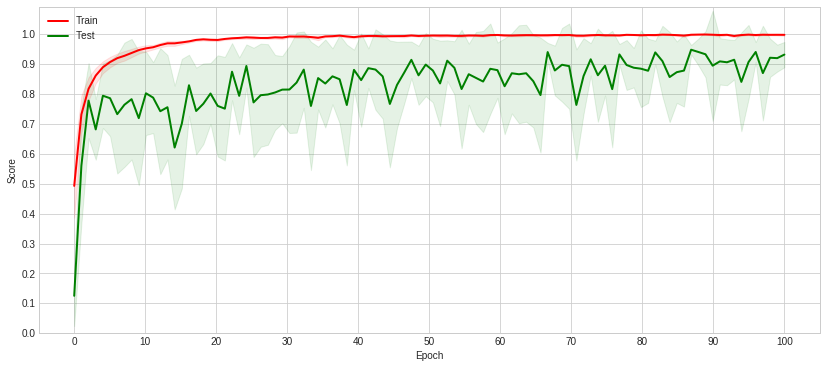

In [5]:
plot_mean_acc(hist)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

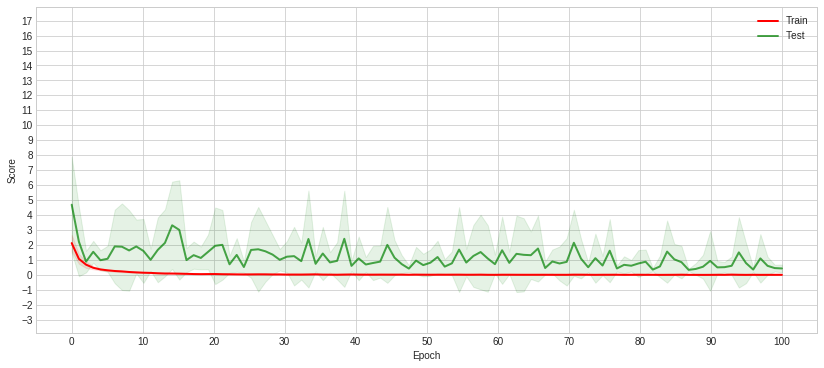

In [7]:
plot_mean_loss(hist)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-10, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

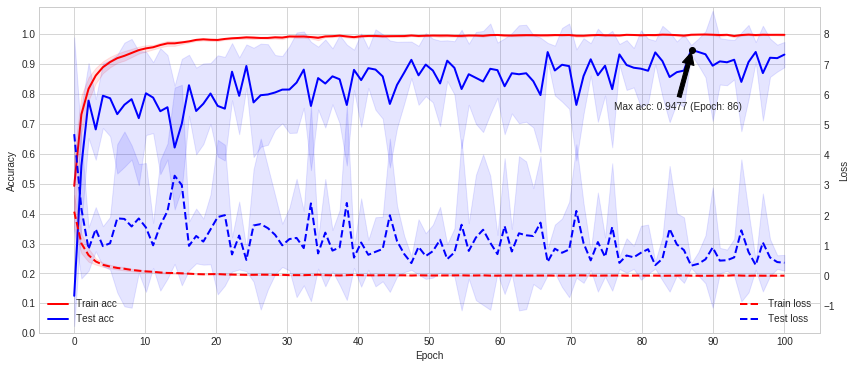

In [13]:
plot_mean(hist)